In [1]:
from datetime import datetime;
today = datetime.today().strftime('%m-%d').replace('-',"").replace(' ',"")

In [2]:
threshold = 0.5

# map_dict_train = {0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7 ,7:8, 8:9,};
map_dict_train = {'other':0, 'Environment':0, 'alarm': 8,
                'en_help': 1, 'ch_help': 2, 'ja_help': 3, 'tw_help': 4, #'hk_help': 5, 'yue_help':6,
                'dog':5, 'cat':6, 'flush':7, 'glass_breaking_selected':9};

# map_dict_train = {0:1, 1:2, 2:3, 3:4, 4:5, 5:6};

choose_class = [0,1,2,3,4,5,6,7,8,9]

pr_rate = 0.8

In [3]:
project_PATH = '/home/sail/sound_project/sound_ai_v4'
# step_now = 'STEP/step_1'
step_now = 'sys/step_1_base_model'

save_model_name = '9C_model_v4'

save_name = f'model_9C_v4_{today}_pr{pr_rate}_byChristine.cc'

Data_npz_path = f'/home/sail/sound_project/DATA/using_data_v4/data_v4.npz'

In [4]:
import os
print(os.getcwd())
import sys
sys.path.append(os.path.abspath(f'{project_PATH}/common'))

import utils as U
import opts as opts;
import calculator as calc;
import tlopts as tlopts
import agent_attention_pytorch as att

from config_utility import *

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datetime import datetime

/home/sail/sound_project/sound_ai_v4/sys


In [5]:
import sys;
import os;
import glob;
import math;
import numpy as np;
import glob;
import random;
from collections import Counter 
import time;

import torch;
from torch.utils.data import  DataLoader
import torch.optim as optim;
import torch.nn as nn;
import torch.nn.functional as F
import json

import argparse
from itertools import repeat
import pathlib



In [6]:
sys.path.append(os.path.abspath(f'{project_PATH}/STEP/sys'))

from model import att_Model
from trainer import TLTrainer

In [7]:

data = np.load(Data_npz_path, allow_pickle=True) 
# audio_max_value =  float((data['sounds_train']).max()) # *2 # the max value of the sound samples
# audio_min_value =  float((data['sounds_train']).min()) # *2 # the max value of the sound samples
print("train",Counter(data['labels_train'].tolist()), "\n val",Counter(data['labels_val'].tolist()))
# audio_max_value, audio_min_value

train Counter({0: 12125, 5: 1550, 2: 1235, 4: 714, 6: 656, 7: 621, 1: 420, 9: 419, 8: 402, 3: 237}) 
 val Counter({0: 218, 5: 55, 6: 52, 2: 50, 4: 42, 7: 42, 1: 38, 9: 38, 3: 30, 8: 20})


In [8]:
# labels = data['labels_train'].tolist()
# samples = data['sounds_train'].tolist()

In [9]:
def genDataTimeStr():
    return datetime.today().strftime('%Y-%m-%d %H:%M:%S').replace('-',"").replace(' ',"").replace(':',"");

def getDateStr():
    return datetime.today().strftime('%Y-%m-%d %H').replace('-',"").replace(' ',"")

In [10]:
def getOpts():
    parser = argparse.ArgumentParser(description='!NO! Transfer Learning and add attention');
    parser.add_argument('--netType', default='add_attention',  required=False);
    parser.add_argument('--BC', default=True, action='store_true', help='BC learning');
    # parser.add_argument('--data', default='../datasets/processed/',  required=False);
    parser.add_argument('--dataset', required=False, default='v4', choices=['10']);
    
    opt, _ = parser.parse_known_args(); #在ipynb中，不能使用parser.parse，要改用parser.parse_known_args()

    opt.project_PATH = project_PATH
    #Basic Net Settings
    opt.nClasses = len(choose_class) #
    opt.threshold = threshold
    opt.nFolds = 1; #
    opt.splits = [i for i in range(1, opt.nFolds + 1)];
    opt.sr = 16000;
    opt.inputLength = 16000;

    opt.Data_npz_path = Data_npz_path
    opt.classes_dict = map_dict_train
    # opt.audio_max_value = audio_max_value
    opt.other_class = 0
    opt.choose_or_not =  True
    opt.choose_class = choose_class
    
    #Leqarning settings
    opt.ch_confing_10 = 32
    opt.fcn_no_of_inputs = opt.nClasses
    opt.ch_n_class = opt.nClasses

    opt.batch_size =  128;
    opt.batchSize = opt.batch_size 
    # opt.lr = 0.01; # 0.1
    opt.lr = 0.1; # 0.1
    opt.weightDecay = 5e-4 #9e-3;#5e-3;#5e-2;#1e-2;#5e-4;
    opt.momentum = 0.9 # 0.9;
    # opt.nEpochs = 300; # 1600
    opt.nEpochs = 300; # 1600
    # opt.schedule = [0.03, 0.05, 0.09, 0.1];
    opt.schedule = [0.3, 0.5, 0.9];
    opt.warmup = 10;
    
    opt.least_save_epoch = 5;
    opt.first_save_acc = 75.0;
    opt.save_val_acc = 99.0;
    opt.save_train_acc = 90.0;


    if torch.backends.mps.is_available():
        opt.device="mps"; #for apple m2 gpu
    elif torch.cuda.is_available():
        opt.device="cuda:0"; #for nVidia gpu
    else:
        opt.device="cpu"

    print(f"***Use device:{opt.device}");

    #Test data
    opt.nCrops = 1;
    opt.TLAcdnetConfig = []

    return opt
    # opt = parser.parse_args();

In [11]:
def ChkAndCreateSingleDir(dir_path):
    if not pathlib.Path(dir_path).is_dir():
        os.mkdir(dir_path);
        print(f"'{dir_path}' folder is created.");

## step1

In [12]:
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
try:
    os.mkdir(f'{project_PATH}/{step_now}/save_pt_model_s1')
except FileExistsError:
    pass
save_pt_model_path = f'{project_PATH}/{step_now}/save_pt_model_s1/{date_time}'
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v4/sys/step_1_base_model/save_pt_model_s1/20241118_16' already exists.


In [13]:
logObj = None;
def main():
    global logObj;
    opt = getOpts()
    opt.best_save_name = None
    opt.trainStartTime = genDataTimeStr();
    opt.modelSaveDir = f'{save_pt_model_path}/base4C_train_lr{opt.lr}_bs{opt.batch_size}_wd{opt.weightDecay}_{opt.trainStartTime}/'

    if not pathlib.Path(opt.modelSaveDir).is_dir():
        os.makedirs(opt.modelSaveDir,exist_ok=True);
        print(f"'{opt.modelSaveDir}' is created.");
    tlopts.display_info(opt)
    opt.model_name = save_model_name+"hacc{:.4f}_valacc{:.4f}_hacctr{:.4f}_tracc{:.4f}_{}th_sum_{:.4f}.pt"
    ###
    logSaveDir = opt.modelSaveDir + "/base_training_logs/"
    opt.logSaveDir = logSaveDir
    ChkAndCreateSingleDir(logSaveDir);
    opt.logName = "BaseTrainLog_{}.log".format(opt.trainStartTime);
    opt.logObj = open(os.path.join(logSaveDir,opt.logName),'w');

    print("Initializing TLTrainer Object.....")
    trainer = TLTrainer(opt)
    print("Start to training.....")
    model = trainer.Train();

    return opt.best_save_name

***Use device:cuda:0
'/home/sail/sound_project/sound_ai_v4/sys/step_1_base_model/save_pt_model_s1/20241118_16/base4C_train_lr0.1_bs128_wd0.0005_20241118161909/' is created.
+------------------------------+
| add_attention Sound classification
+------------------------------+
| dataset  : v4
| nEpochs  : 300
| LRInit   : 0.1
| batchSize: 128
| Momentum   : 0.9
| weightDecay: 0.0005
| schedule : [0.3, 0.5, 0.9]
| warmup   : 10
| nFolds: 1
| Splits: [1]
+------------------------------+
'/home/sail/sound_project/sound_ai_v4/sys/step_1_base_model/save_pt_model_s1/20241118_16/base4C_train_lr0.1_bs128_wd0.0005_20241118161909//base_training_logs/' folder is created.
Initializing TLTrainer Object.....
Start to training.....
self.opt.ch_confing_10 32
self.ch_config [1, 16, 32, 1, 64, 32, 64, 32, 16, 16, 6]
sfeb.0.weight:True
sfeb.1.weight:True
sfeb.1.bias:True
sfeb.3.weight:True
sfeb.4.weight:True
sfeb.4.bias:True
tfeb.0.weight:True
tfeb.1.weight:True
tfeb.1.bias:True
tfeb.4.weight:True
tfeb.5.w

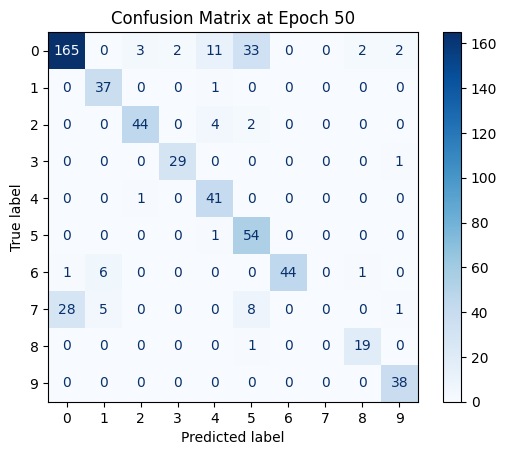

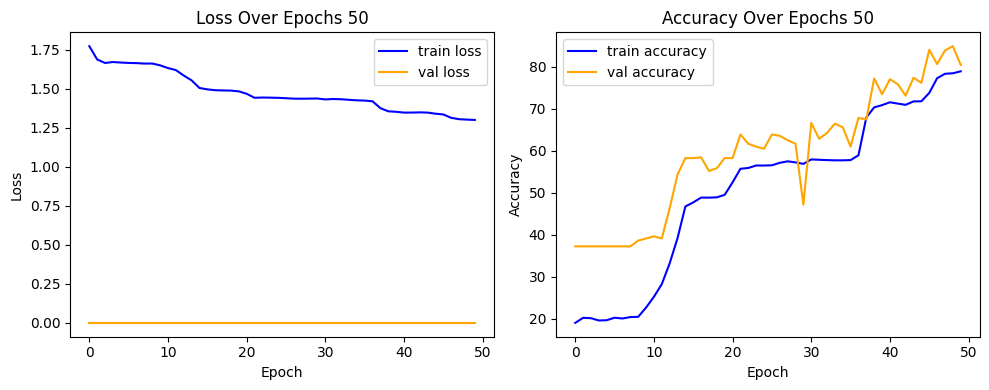

save model to /home/sail/sound_project/sound_ai_v4/sys/step_1_base_model/save_pt_model_s1/20241118_16/base4C_train_lr0.1_bs128_wd0.0005_20241118161909/9C_model_v4hacc84.1026_valacc84.1026_hacctr78.9659_tracc78.1467_51th_sum_325.3178.pt
SP-[1] Epoch: 51/300 | Time: 0m47s (Train 0m47s  Val 0m00s) | Train: lr 0.1  Loss 1.3051  Acc 78.15% | HA 78.97@50 | Val: Loss nan  Acc 84.10% | HA 84.10@51 | Sum 162.25 HA 163.07
SP-[1] Epoch: 52/300 | Time: 0m46s (Train 0m46s  Val 0m00s) | Train: lr 0.1  Loss 1.3012  Acc 78.59% | HA 78.97@50 | Val: Loss nan  Acc 79.15% | HA 84.10@51 | Sum 157.74 HA 163.07
save model to /home/sail/sound_project/sound_ai_v4/sys/step_1_base_model/save_pt_model_s1/20241118_16/base4C_train_lr0.1_bs128_wd0.0005_20241118161909/9C_model_v4hacc84.1026_valacc83.0769_hacctr79.0744_tracc79.0744_53th_sum_325.3284.pt
SP-[1] Epoch: 53/300 | Time: 0m47s (Train 0m47s  Val 0m00s) | Train: lr 0.1  Loss 1.2993  Acc 79.07% | HA 79.07@53 | Val: Loss nan  Acc 83.08% | HA 84.10@51 | Sum 162.1

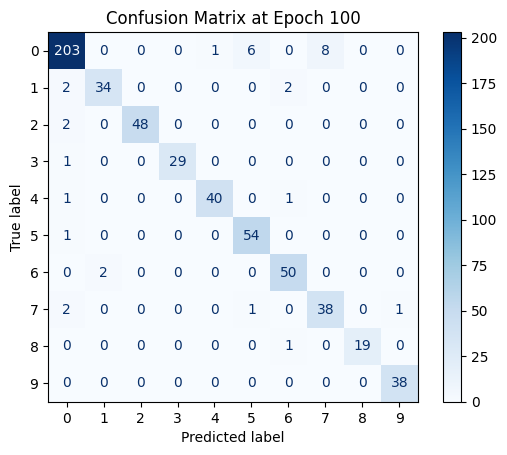

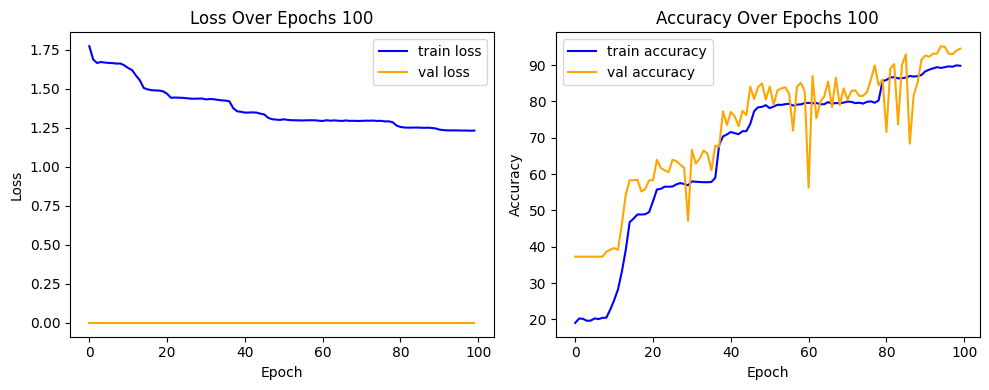

SP-[1] Epoch: 101/300 | Time: 0m46s (Train 0m46s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.2322  Acc 89.72% | HA 89.93@99 | Val: Loss nan  Acc 93.33% | HA 95.21@95 | Sum 183.05 HA 185.14
SP-[1] Epoch: 102/300 | Time: 0m46s (Train 0m46s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.2324  Acc 89.64% | HA 89.93@99 | Val: Loss nan  Acc 94.53% | HA 95.21@95 | Sum 184.17 HA 185.14
save model to /home/sail/sound_project/sound_ai_v4/sys/step_1_base_model/save_pt_model_s1/20241118_16/base4C_train_lr0.1_bs128_wd0.0005_20241118161909/9C_model_v4hacc95.2137_valacc95.2137_hacctr89.9306_tracc89.8058_103th_sum_370.1637.pt
SP-[1] Epoch: 103/300 | Time: 0m46s (Train 0m46s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.2321  Acc 89.81% | HA 89.93@99 | Val: Loss nan  Acc 95.21% | HA 95.21@103 | Sum 185.02 HA 185.14
save model to /home/sail/sound_project/sound_ai_v4/sys/step_1_base_model/save_pt_model_s1/20241118_16/base4C_train_lr0.1_bs128_wd0.0005_20241118161909/9C_model_v4hacc95

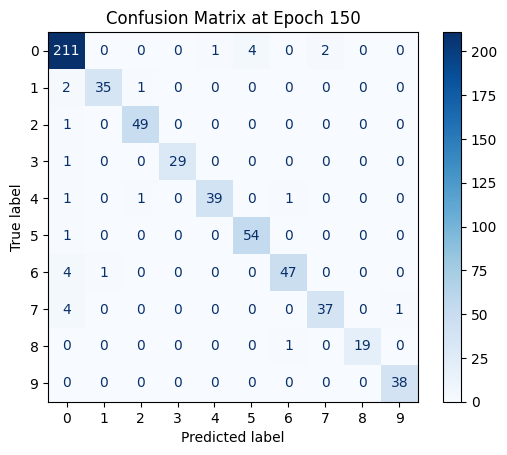

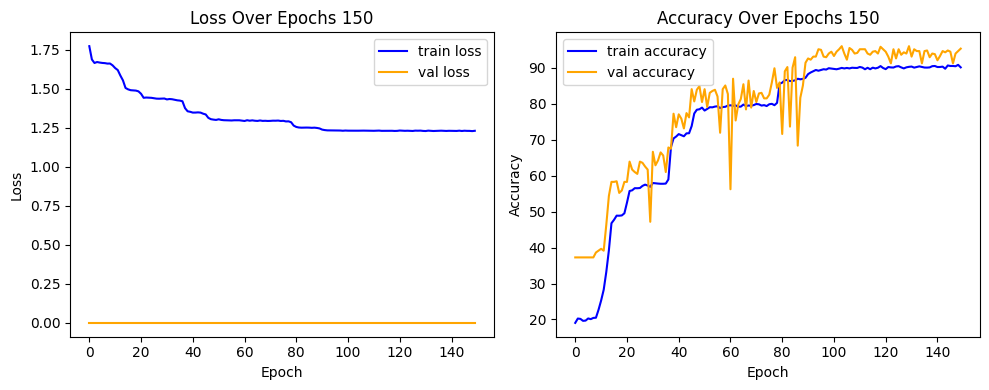

save model to /home/sail/sound_project/sound_ai_v4/sys/step_1_base_model/save_pt_model_s1/20241118_16/base4C_train_lr0.1_bs128_wd0.0005_20241118161909/9C_model_v4hacc96.0684_valacc94.7009_hacctr90.8691_tracc90.5599_150th_sum_372.1983.pt
SP-[1] Epoch: 151/300 | Time: 0m46s (Train 0m46s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2304  Acc 90.56% | HA 90.87@149 | Val: Loss nan  Acc 94.70% | HA 96.07@130 | Sum 185.26 HA 186.94
save model to /home/sail/sound_project/sound_ai_v4/sys/step_1_base_model/save_pt_model_s1/20241118_16/base4C_train_lr0.1_bs128_wd0.0005_20241118161909/9C_model_v4hacc96.0684_valacc94.8718_hacctr90.8691_tracc90.5707_151th_sum_372.3801.pt
SP-[1] Epoch: 152/300 | Time: 0m46s (Train 0m46s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2295  Acc 90.57% | HA 90.87@149 | Val: Loss nan  Acc 94.87% | HA 96.07@130 | Sum 185.44 HA 186.94
save model to /home/sail/sound_project/sound_ai_v4/sys/step_1_base_model/save_pt_model_s1/20241118_16/base4C_train_lr0.1_bs1

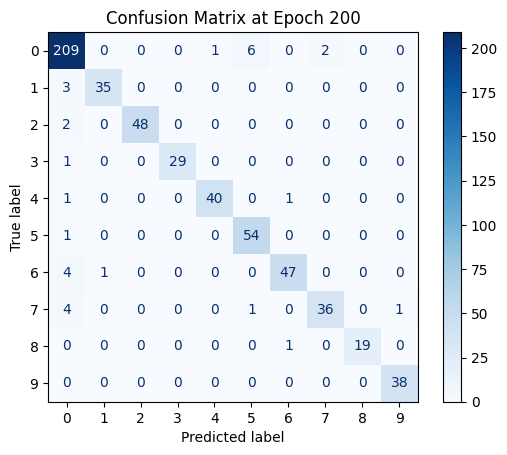

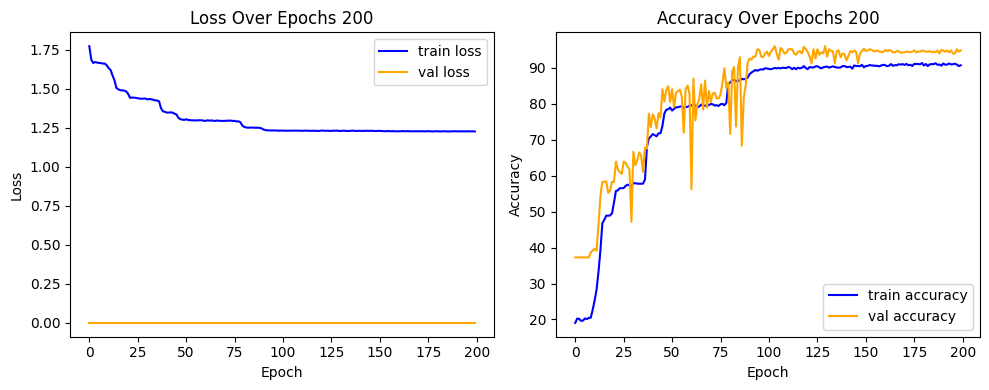

save model to /home/sail/sound_project/sound_ai_v4/sys/step_1_base_model/save_pt_model_s1/20241118_16/base4C_train_lr0.1_bs128_wd0.0005_20241118161909/9C_model_v4hacc96.0684_valacc94.5299_hacctr91.3900_tracc90.7172_200th_sum_372.7055.pt
SP-[1] Epoch: 201/300 | Time: 0m46s (Train 0m46s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2281  Acc 90.72% | HA 91.39@180 | Val: Loss nan  Acc 94.53% | HA 96.07@130 | Sum 185.25 HA 187.46
save model to /home/sail/sound_project/sound_ai_v4/sys/step_1_base_model/save_pt_model_s1/20241118_16/base4C_train_lr0.1_bs128_wd0.0005_20241118161909/9C_model_v4hacc96.0684_valacc94.7009_hacctr91.3900_tracc90.8203_201th_sum_372.9795.pt
SP-[1] Epoch: 202/300 | Time: 0m46s (Train 0m46s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2273  Acc 90.82% | HA 91.39@180 | Val: Loss nan  Acc 94.70% | HA 96.07@130 | Sum 185.52 HA 187.46
save model to /home/sail/sound_project/sound_ai_v4/sys/step_1_base_model/save_pt_model_s1/20241118_16/base4C_train_lr0.1_bs1

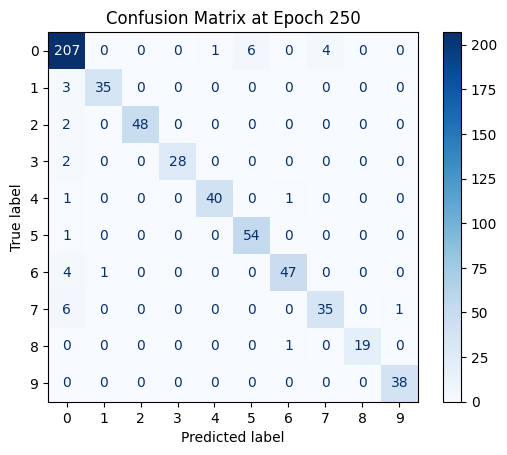

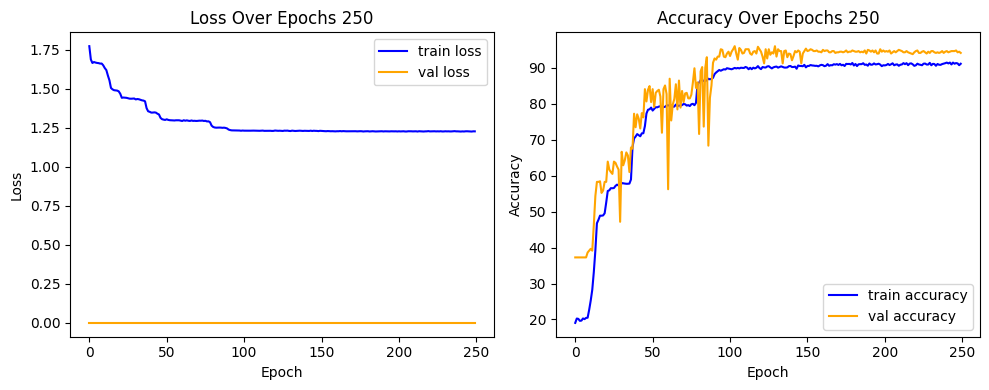

save model to /home/sail/sound_project/sound_ai_v4/sys/step_1_base_model/save_pt_model_s1/20241118_16/base4C_train_lr0.1_bs128_wd0.0005_20241118161909/9C_model_v4hacc96.0684_valacc94.0171_hacctr91.5039_tracc91.0373_250th_sum_372.6267.pt
SP-[1] Epoch: 251/300 | Time: 0m46s (Train 0m46s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2271  Acc 91.04% | HA 91.50@243 | Val: Loss nan  Acc 94.02% | HA 96.07@130 | Sum 185.05 HA 187.57
save model to /home/sail/sound_project/sound_ai_v4/sys/step_1_base_model/save_pt_model_s1/20241118_16/base4C_train_lr0.1_bs128_wd0.0005_20241118161909/9C_model_v4hacc96.0684_valacc94.3590_hacctr91.5039_tracc90.8420_251th_sum_372.7733.pt
SP-[1] Epoch: 252/300 | Time: 0m46s (Train 0m46s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2278  Acc 90.84% | HA 91.50@243 | Val: Loss nan  Acc 94.36% | HA 96.07@130 | Sum 185.20 HA 187.57
save model to /home/sail/sound_project/sound_ai_v4/sys/step_1_base_model/save_pt_model_s1/20241118_16/base4C_train_lr0.1_bs1

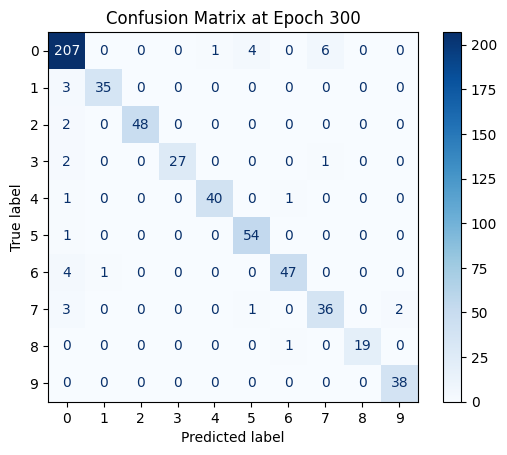

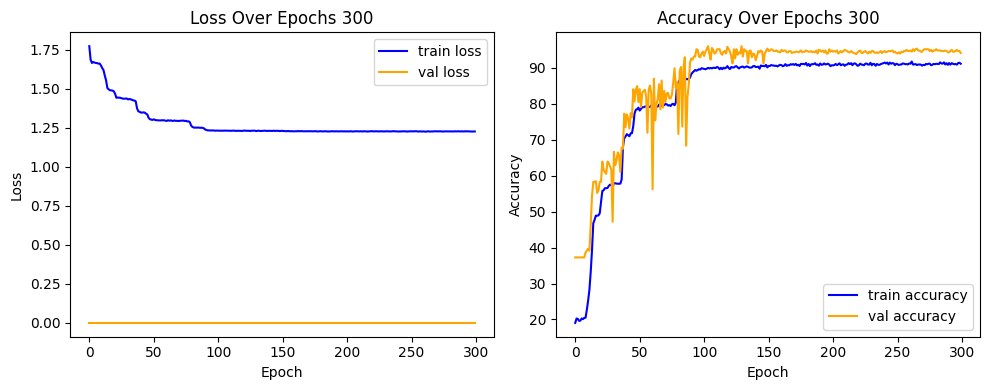

Execution finished in: 3h52m
save model to /home/sail/sound_project/sound_ai_v4/sys/step_1_base_model/save_pt_model_s1/20241118_16/base4C_train_lr0.1_bs128_wd0.0005_20241118161909/9C_model_v4hacc96.0684_valacc94.1880_hacctr91.7860_tracc91.1730_299th_sum_373.2154.pt
374.28977966308594


In [14]:
step_1_model_path = main()
# main()


In [15]:
step_1_model_path

'/home/sail/sound_project/sound_ai_v4/sys/step_1_base_model/save_pt_model_s1/20241118_16/base4C_train_lr0.1_bs128_wd0.0005_20241118161909/9C_model_v4hacc96.0684_valacc94.8718_hacctr91.7860_tracc91.5636_283th_sum_374.2898.pt'

## step 2

In [16]:
step_now = 'sys/step_2_pruning'

In [17]:
# step_1_model_path = '/home/sail/sound_project/sound_ai_v2.2.2/sys/step1_base_model/save_pt_model_s1/20241007_17/base4C_train_lr0.1_bs64_wd0.0005_20241007173709/9C_att_model_hacc100.0000_valacc99.1071_hacctr90.5093_tracc90.5093_298th_sum_380.1257.pt'

In [18]:
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_step_path = f'{project_PATH}/{step_now}'
save_pt_model_path = f'{save_step_path}/{date_time}'
try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
    
save_step_path = f'{project_PATH}/{step_now}/save_pt_model_s2'

try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
    
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v4/sys/step_2_pruning' already exists.
Folder '/home/sail/sound_project/sound_ai_v4/sys/step_2_pruning/save_pt_model_s2' already exists.
Folder '/home/sail/sound_project/sound_ai_v4/sys/step_2_pruning/20241118_20' created successfully.


In [19]:
from sparsify import PruningTrainer


In [20]:
def main():
    global logObj;
    opt = getOpts()
    opt.trainer = None

    # opt.nEpochs = 300;
    # opt.least_save_epoch = 50;
    # opt.first_save_acc = 75.0;
    # opt.save_val_acc = 95.0;
    opt.save_train_acc = 90.0;

    opt.prune_ratio = pr_rate
    opt.base_model_path = step_1_model_path
    trainStartTime = getDateStr();
    save_dir = f"{save_pt_model_path}/pruning_4C_time_{trainStartTime}_prunratio{opt.prune_ratio*100}/"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    opt.save_dir = save_dir;
    opt.model_name = save_model_name+"_first_stage_prun_haacc_{:.4f}_valacc{:.4f}_tracc{:.4f}_epoch_{}.pt";
    print("Initializing PruneAndTrain Object.....")
    trainer = PruningTrainer(opt)#TLTrainer(opt)
    print("Start to pruning.....")
    logSaveDir = opt.save_dir+"/first_stage_pruning_logs/"
    opt.logSaveDir = logSaveDir
    ChkAndCreateSingleDir(logSaveDir);
    logName = "FirstPruningLog_{}.log".format(trainStartTime);
    opt.logObj = open(os.path.join(logSaveDir,logName),'w');
    trainer.PruneAndTrain();
    opt.logObj.flush();
    opt.logObj.close();
    return opt.best_save_name

***Use device:cuda:0
Initializing PruneAndTrain Object.....
!!! In PruningTrainer:: current used device:cuda:0
Start to pruning.....
'/home/sail/sound_project/sound_ai_v4/sys/step_2_pruning/20241118_20/pruning_4C_time_2024111820_prunratio80.0//first_stage_pruning_logs/' folder is created.
cuda:0
self.opt.ch_confing_10 32
self.ch_config [1, 16, 32, 1, 64, 32, 64, 32, 16, 16, 6]
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)     (16, 1, 7996)        144    1,151,424
  BatchNorm2d-2     (16, 1, 7996)     (16, 1, 7996)         32            0
         ReLu-3     (16, 1, 7996)     (16, 1, 7996)          0      127,936
       Conv2d-4     (16, 1, 7996)     (32, 1, 3996)      2,560   10,229,760
  B

/home/sail/sound_project/sound_ai_v4/sys/sparsify.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(self.opt.base_model_path, map_location=

save model to /home/sail/sound_project/sound_ai_v4/sys/step_2_pruning/20241118_20/pruning_4C_time_2024111820_prunratio80.0/9C_model_v4_first_stage_prun_haacc_94.0171_valacc94.0171_tracc86.5940_epoch_1.pt
SP-[1] Epoch: 1/300 | Time: 0m46s (Train 0m46s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.2610  Acc 86.59% | HA 0.00@0 | Val: Loss nan  Acc 94.02% | HA 0.00@0 | Sum 180.61 HA 0.00
save model to /home/sail/sound_project/sound_ai_v4/sys/step_2_pruning/20241118_20/pruning_4C_time_2024111820_prunratio80.0/9C_model_v4_first_stage_prun_haacc_94.7009_valacc94.7009_tracc88.8075_epoch_2.pt
SP-[1] Epoch: 2/300 | Time: 0m46s (Train 0m46s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.2428  Acc 88.81% | HA 0.00@0 | Val: Loss nan  Acc 94.70% | HA 0.00@0 | Sum 183.51 HA 0.00
save model to /home/sail/sound_project/sound_ai_v4/sys/step_2_pruning/20241118_20/pruning_4C_time_2024111820_prunratio80.0/9C_model_v4_first_stage_prun_haacc_95.2137_valacc95.2137_tracc88.7153_epoch_3.pt
SP-[1] E

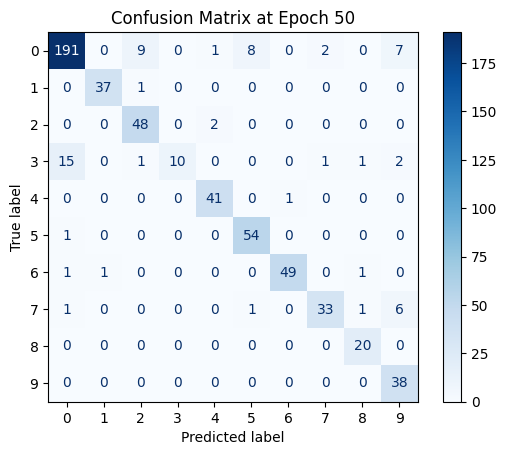

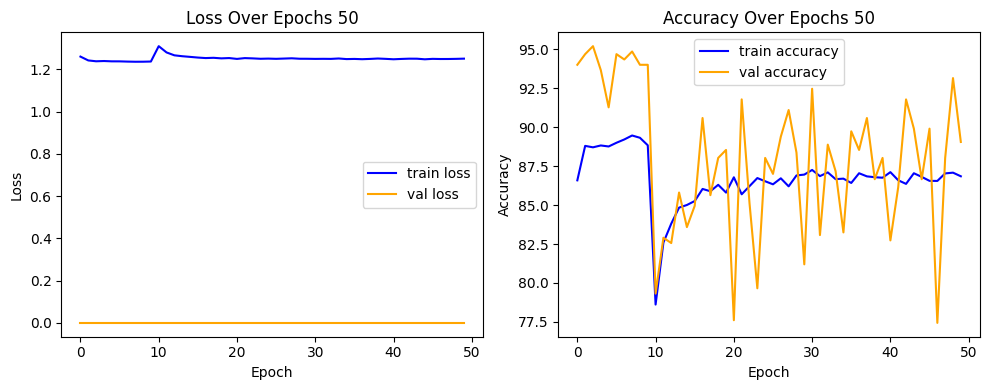

SP-[1] Epoch: 51/300 | Time: 0m46s (Train 0m46s  Val 0m00s) | Train: lr 0.1  Loss 1.2511  Acc 86.88% | HA 0.00@0 | Val: Loss nan  Acc 87.35% | HA 0.00@0 | Sum 174.23 HA 0.00
SP-[1] Epoch: 52/300 | Time: 0m46s (Train 0m46s  Val 0m00s) | Train: lr 0.1  Loss 1.2512  Acc 86.53% | HA 0.00@0 | Val: Loss nan  Acc 87.01% | HA 0.00@0 | Sum 173.54 HA 0.00
SP-[1] Epoch: 53/300 | Time: 0m46s (Train 0m46s  Val 0m00s) | Train: lr 0.1  Loss 1.2468  Acc 87.59% | HA 0.00@0 | Val: Loss nan  Acc 93.33% | HA 0.00@0 | Sum 180.93 HA 0.00
SP-[1] Epoch: 54/300 | Time: 0m46s (Train 0m46s  Val 0m00s) | Train: lr 0.1  Loss 1.2494  Acc 86.74% | HA 0.00@0 | Val: Loss nan  Acc 89.06% | HA 0.00@0 | Sum 175.79 HA 0.00
SP-[1] Epoch: 55/300 | Time: 0m46s (Train 0m46s  Val 0m00s) | Train: lr 0.1  Loss 1.2506  Acc 86.70% | HA 0.00@0 | Val: Loss nan  Acc 89.57% | HA 0.00@0 | Sum 176.28 HA 0.00
SP-[1] Epoch: 56/300 | Time: 0m46s (Train 0m46s  Val 0m00s) | Train: lr 0.1  Loss 1.2476  Acc 87.08% | HA 0.00@0 | Val: Loss nan  

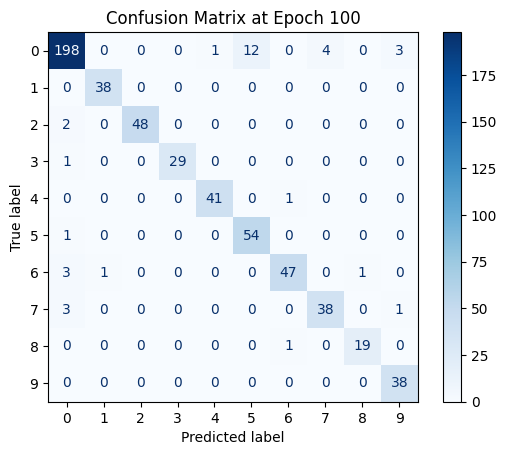

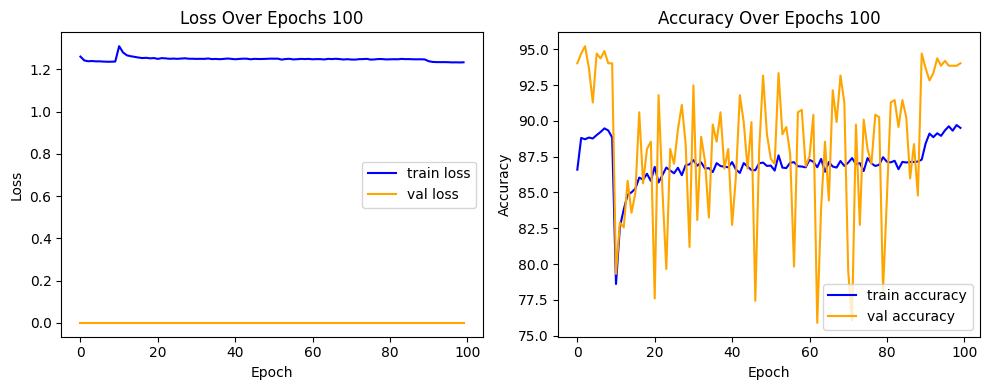

SP-[1] Epoch: 101/300 | Time: 0m51s (Train 0m51s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.2339  Acc 89.38% | HA 0.00@0 | Val: Loss nan  Acc 92.99% | HA 0.00@0 | Sum 182.37 HA 0.00
SP-[1] Epoch: 102/300 | Time: 0m51s (Train 0m51s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.2332  Acc 89.54% | HA 0.00@0 | Val: Loss nan  Acc 94.19% | HA 0.00@0 | Sum 183.73 HA 0.00
SP-[1] Epoch: 103/300 | Time: 0m50s (Train 0m50s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.2339  Acc 89.43% | HA 0.00@0 | Val: Loss nan  Acc 93.85% | HA 0.00@0 | Sum 183.28 HA 0.00
save model to /home/sail/sound_project/sound_ai_v4/sys/step_2_pruning/20241118_20/pruning_4C_time_2024111820_prunratio80.0/9C_model_v4_first_stage_prun_haacc_95.2137_valacc94.7009_tracc89.8220_epoch_104.pt
SP-[1] Epoch: 104/300 | Time: 0m50s (Train 0m50s  Val 0m00s) | Train: lr 0.010000000000000002  Loss 1.2331  Acc 89.82% | HA 0.00@0 | Val: Loss nan  Acc 94.70% | HA 0.00@0 | Sum 184.52 HA 0.00
SP-[1] Epoch: 105/300 | Ti

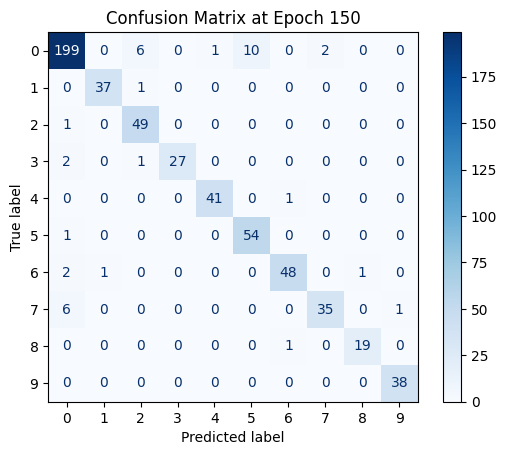

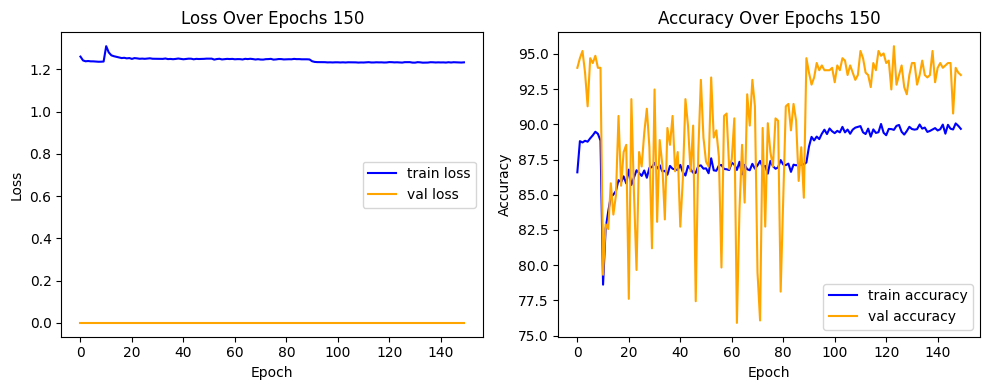

SP-[1] Epoch: 151/300 | Time: 0m50s (Train 0m50s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2337  Acc 89.56% | HA 0.00@0 | Val: Loss nan  Acc 94.19% | HA 0.00@0 | Sum 183.75 HA 0.00
save model to /home/sail/sound_project/sound_ai_v4/sys/step_2_pruning/20241118_20/pruning_4C_time_2024111820_prunratio80.0/9C_model_v4_first_stage_prun_haacc_95.5556_valacc94.5299_tracc90.0716_epoch_152.pt
SP-[1] Epoch: 152/300 | Time: 0m50s (Train 0m50s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2328  Acc 90.07% | HA 0.00@0 | Val: Loss nan  Acc 94.53% | HA 0.00@0 | Sum 184.60 HA 0.00
save model to /home/sail/sound_project/sound_ai_v4/sys/step_2_pruning/20241118_20/pruning_4C_time_2024111820_prunratio80.0/9C_model_v4_first_stage_prun_haacc_95.5556_valacc94.7009_tracc90.1693_epoch_153.pt
SP-[1] Epoch: 153/300 | Time: 0m50s (Train 0m50s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2323  Acc 90.17% | HA 0.00@0 | Val: Loss nan  Acc 94.70% | HA 0.00@0 | Sum 184.87 HA 0.00
save mode

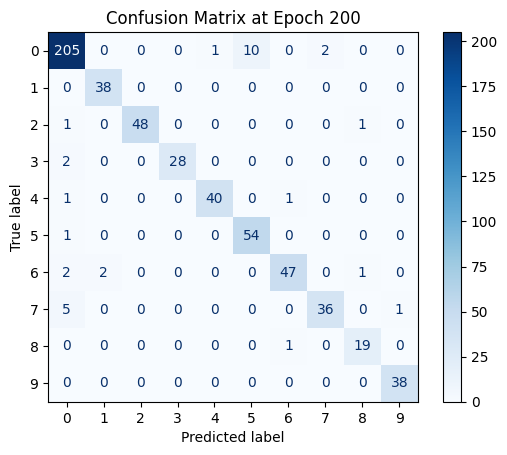

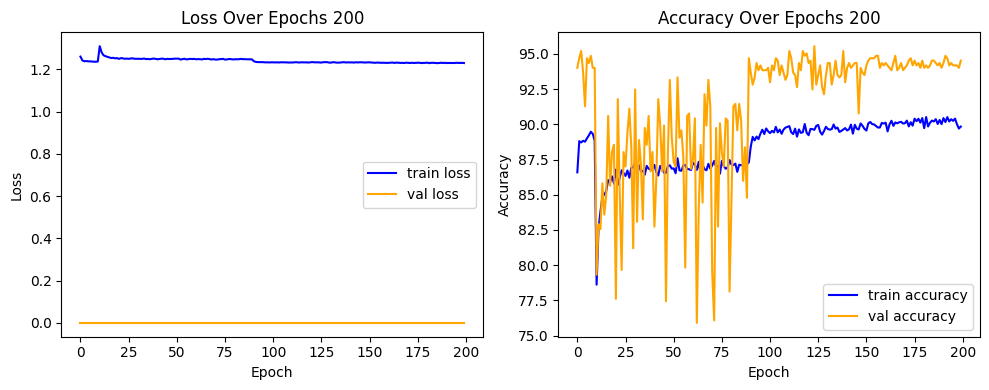

SP-[1] Epoch: 201/300 | Time: 0m51s (Train 0m51s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2313  Acc 89.86% | HA 0.00@0 | Val: Loss nan  Acc 94.02% | HA 0.00@0 | Sum 183.88 HA 0.00
SP-[1] Epoch: 202/300 | Time: 0m51s (Train 0m51s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2307  Acc 89.79% | HA 0.00@0 | Val: Loss nan  Acc 94.02% | HA 0.00@0 | Sum 183.81 HA 0.00
save model to /home/sail/sound_project/sound_ai_v4/sys/step_2_pruning/20241118_20/pruning_4C_time_2024111820_prunratio80.0/9C_model_v4_first_stage_prun_haacc_95.5556_valacc94.5299_tracc90.1421_epoch_203.pt
SP-[1] Epoch: 203/300 | Time: 0m51s (Train 0m51s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2310  Acc 90.14% | HA 0.00@0 | Val: Loss nan  Acc 94.53% | HA 0.00@0 | Sum 184.67 HA 0.00
SP-[1] Epoch: 204/300 | Time: 0m51s (Train 0m51s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2316  Acc 89.97% | HA 0.00@0 | Val: Loss nan  Acc 94.53% | HA 0.00@0 | Sum 184.50 HA 0.00
save model to /home/sa

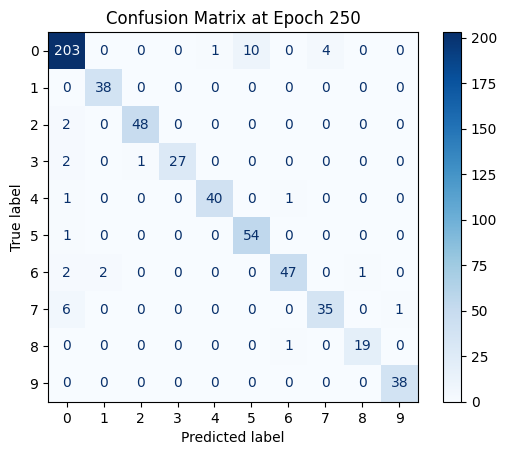

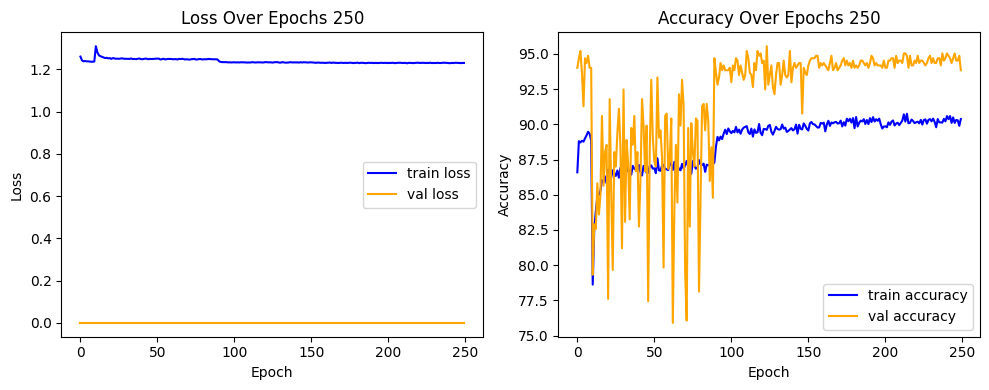

save model to /home/sail/sound_project/sound_ai_v4/sys/step_2_pruning/20241118_20/pruning_4C_time_2024111820_prunratio80.0/9C_model_v4_first_stage_prun_haacc_95.5556_valacc94.8718_tracc90.3212_epoch_251.pt
SP-[1] Epoch: 251/300 | Time: 0m50s (Train 0m50s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2306  Acc 90.32% | HA 0.00@0 | Val: Loss nan  Acc 94.87% | HA 0.00@0 | Sum 185.19 HA 0.00
save model to /home/sail/sound_project/sound_ai_v4/sys/step_2_pruning/20241118_20/pruning_4C_time_2024111820_prunratio80.0/9C_model_v4_first_stage_prun_haacc_95.5556_valacc95.0427_tracc90.0770_epoch_252.pt
SP-[1] Epoch: 252/300 | Time: 0m50s (Train 0m50s  Val 0m00s) | Train: lr 0.0010000000000000002  Loss 1.2313  Acc 90.08% | HA 0.00@0 | Val: Loss nan  Acc 95.04% | HA 0.00@0 | Sum 185.12 HA 0.00
save model to /home/sail/sound_project/sound_ai_v4/sys/step_2_pruning/20241118_20/pruning_4C_time_2024111820_prunratio80.0/9C_model_v4_first_stage_prun_haacc_95.5556_valacc94.5299_tracc90.0119_epoch_253

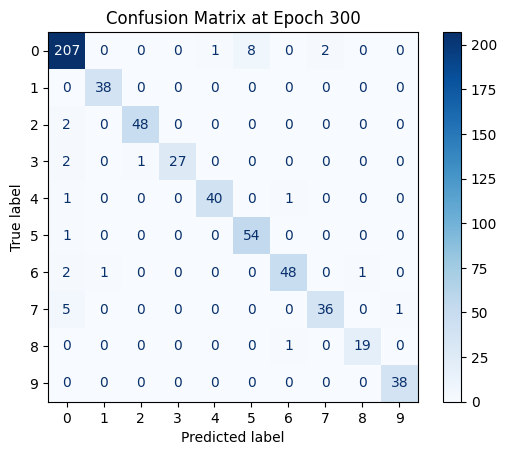

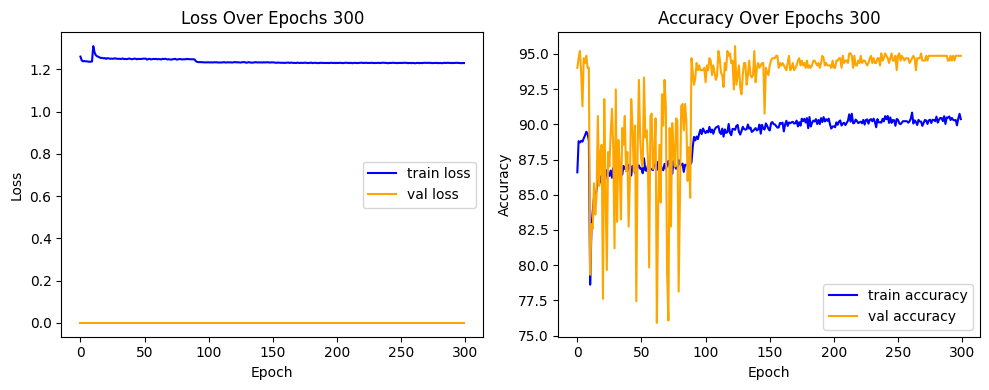

Execution finished in: 4h09m
save model to /home/sail/sound_project/sound_ai_v4/sys/step_2_pruning/20241118_20/pruning_4C_time_2024111820_prunratio80.0/9C_model_v4_first_stage_prun_haacc_95.5556_valacc94.8718_tracc90.3754_epoch_300.pt


In [21]:
step_2_model_path = main()


In [22]:
step_2_model_path

'/home/sail/sound_project/sound_ai_v4/sys/step_2_pruning/20241118_20/pruning_4C_time_2024111820_prunratio80.0/9C_model_v4_first_stage_prun_haacc_95.5556_valacc95.0427_tracc90.7118_epoch_213.pt'

## step3

In [23]:
# step_2_model_path = '/home/sail/sound_project/sound_ai_v4/sys/step_2_pruning/20241030_13/pruning_4C_time_2024103013_prunratio80.0/9C_model_v4_first_stage_prun_haacc_92.5287_valacc91.3793_tracc97.9044_epoch_140.pt'

In [24]:
step_now = 'sys/step_3_pruning'
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_step_path = f'{project_PATH}/{step_now}'
save_pt_model_path = f'{save_step_path}/{date_time}'
try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
save_step_path = f'{project_PATH}/{step_now}/save_pt_model_s3'

try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
    
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v4/sys/step_3_pruning' already exists.
Folder '/home/sail/sound_project/sound_ai_v4/sys/step_3_pruning/save_pt_model_s3' already exists.
Folder '/home/sail/sound_project/sound_ai_v4/sys/step_3_pruning/20241119_00' created successfully.


In [25]:
from pruning import PruningTrainer


In [26]:
def main():
    opt = getOpts()
    
    
    opt.prune_ratio = pr_rate # 0.9
    opt.prune_all = True;

    opt.base_model_path = step_2_model_path

    save_dir = f"{save_pt_model_path}/uec_secondPrun_time_{getDateStr()}_prunratio{opt.prune_ratio*100}/"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)

    opt.save_dir = save_dir;
    model_name = save_model_name+"second_stage_prun_ratio{}_{}.pt".format(opt.prune_ratio, genDataTimeStr());
    opt.model_name = save_dir + model_name;
    opt.logSaveDir = opt.save_dir+"/second_stage_pruning_logs/"
    ChkAndCreateSingleDir(opt.logSaveDir)
    # valid_path = False;
    print("Initializing PruneAndTrain Object.....")
    trainer = PruningTrainer(opt=opt)
    print("Start to pruning.....")
    trainer.PruneAndTrain();
    return opt.model_name

***Use device:cuda:0
'/home/sail/sound_project/sound_ai_v4/sys/step_3_pruning/20241119_00/uec_secondPrun_time_2024111900_prunratio80.0//second_stage_pruning_logs/' folder is created.
Initializing PruneAndTrain Object.....
device is: cuda:0
Start to pruning.....
self.opt.ch_confing_10 32
self.ch_config [1, 16, 32, 1, 64, 32, 64, 32, 16, 16, 6]
 --- chonfig[1, 16, 32, 1, 64, 32, 64, 32, 16, 16, 6]
pruning algorithm is <th.resources.pruning_tools.filter_pruning.Taylor object at 0x7a7216d7b7c0>
Current Testing Performance - Val: Loss nan  Acc(top1) 95.043%
Total Channels: 256, Prunable: 256, Non-Prunable: 0
No. of Channels to prune per iteration: 1
Total Channels to prune (80%): 203
Total iterations required: 203

Iteration 1 of 203 starts..
Ranking channels.. 


/home/sail/sound_project/sound_ai_v4/sys/pruning.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(trained_model, map_location=self.op

new_conv Conv2d(1, 63, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) new_bn BatchNorm2d(63, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Current Testing Performance - Val: Loss nan  Acc(top1) 94.701%
Fine tuning 2 epochs to recover from prunning iteration.
config[16, 32, 63, 32, 64, 32, 16]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(1, 5), stride=(1, 2), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(1, 40), stride=(1, 40), padding=0, dilation=1, ceil_mode=False)
  )
  (tfeb): Sequential(
    (0): Conv2d(1, 63, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2

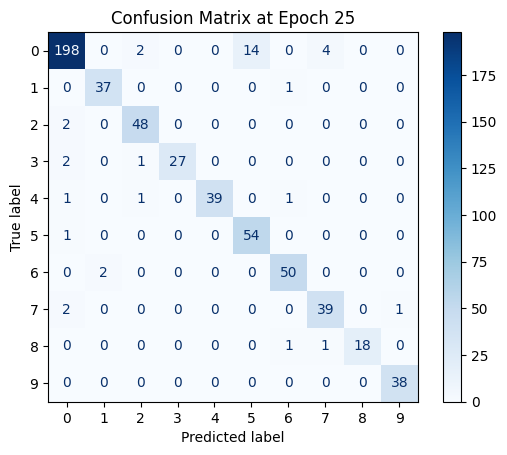

Current Testing Performance - Val: Loss nan  Acc(top1) 37.265%
Current Testing Performance - Val: Loss nan  Acc(top1) 79.829%
Finished fine tuning.
Iteration 24/205 finished in 2m31s
Total channels prunned so far: 24
 --- chonfig[15, 32, 51, 31, 57, 30, 16]
 --- save model at /home/sail/sound_project/sound_ai_v4/sys/step_3_pruning/20241119_00/uec_secondPrun_time_2024111900_prunratio80.0/9C_model_v4second_stage_prun_ratio0.8_20241119002153.pt --- 

Iteration 25 of 203 starts..
Ranking channels.. 
new_conv Conv2d(31, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) new_bn BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Current Testing Performance - Val: Loss nan  Acc(top1) 81.709%
Fine tuning 2 epochs to recover from prunning iteration.
config[15, 32, 51, 31, 56, 30, 16]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 15, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1

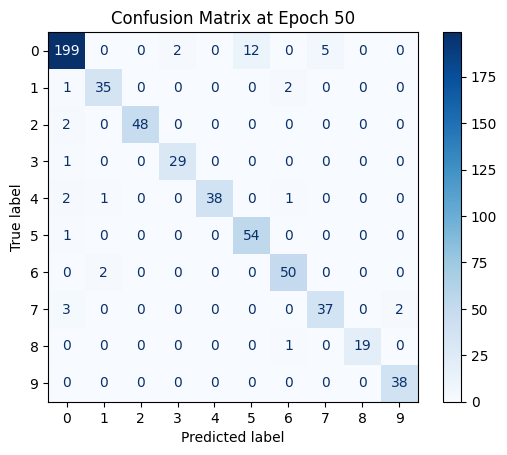

Current Testing Performance - Val: Loss nan  Acc(top1) 38.632%
Current Testing Performance - Val: Loss nan  Acc(top1) 87.350%
Finished fine tuning.
Iteration 49/205 finished in 2m31s
Total channels prunned so far: 49
 --- chonfig[14, 32, 45, 27, 47, 26, 16]
 --- save model at /home/sail/sound_project/sound_ai_v4/sys/step_3_pruning/20241119_00/uec_secondPrun_time_2024111900_prunratio80.0/9C_model_v4second_stage_prun_ratio0.8_20241119002153.pt --- 

Iteration 50 of 203 starts..
Ranking channels.. 
new_conv Conv2d(1, 13, kernel_size=(1, 9), stride=(1, 2), bias=False) new_bn BatchNorm2d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Current Testing Performance - Val: Loss nan  Acc(top1) 90.769%
Fine tuning 2 epochs to recover from prunning iteration.
config[13, 32, 45, 27, 47, 26, 16]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 13, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(13

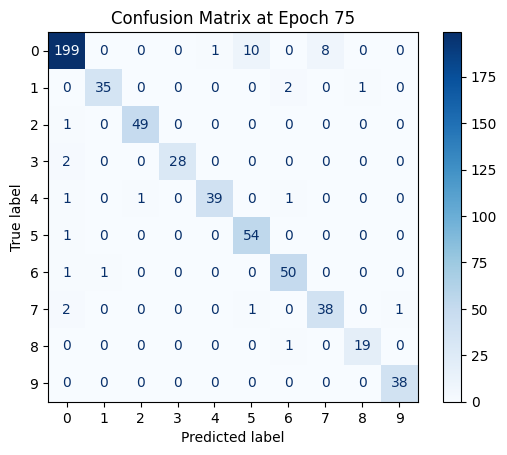

Current Testing Performance - Val: Loss nan  Acc(top1) 92.991%
Current Testing Performance - Val: Loss nan  Acc(top1) 93.675%
Finished fine tuning.
Iteration 74/205 finished in 2m16s
Total channels prunned so far: 74
 --- chonfig[8, 32, 45, 27, 46, 26, 16]
 --- save model at /home/sail/sound_project/sound_ai_v4/sys/step_3_pruning/20241119_00/uec_secondPrun_time_2024111900_prunratio80.0/9C_model_v4second_stage_prun_ratio0.8_20241119002153.pt --- 

Iteration 75 of 203 starts..
Ranking channels.. 
Skipping pruning for layer 0 as it would reduce channels below 4
Current Testing Performance - Val: Loss nan  Acc(top1) 93.504%
Fine tuning 2 epochs to recover from prunning iteration.
config[8, 32, 45, 27, 46, 26, 16]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2

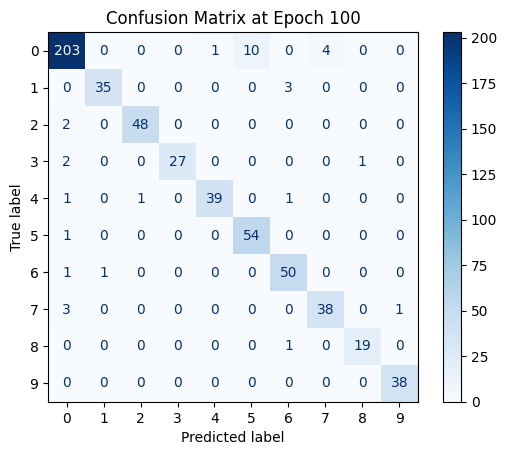

Current Testing Performance - Val: Loss nan  Acc(top1) 94.872%
Current Testing Performance - Val: Loss nan  Acc(top1) 94.872%
Finished fine tuning.
Iteration 99/205 finished in 2m16s
Total channels prunned so far: 99
 --- chonfig[8, 32, 45, 27, 46, 26, 16]
 --- save model at /home/sail/sound_project/sound_ai_v4/sys/step_3_pruning/20241119_00/uec_secondPrun_time_2024111900_prunratio80.0/9C_model_v4second_stage_prun_ratio0.8_20241119002153.pt --- 

Iteration 100 of 203 starts..
Ranking channels.. 
Skipping pruning for layer 0 as it would reduce channels below 4
Current Testing Performance - Val: Loss nan  Acc(top1) 94.188%
Fine tuning 2 epochs to recover from prunning iteration.
config[8, 32, 45, 27, 46, 26, 16]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv

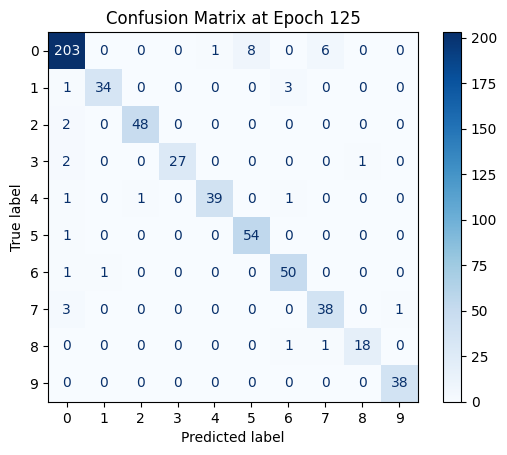

Current Testing Performance - Val: Loss nan  Acc(top1) 94.530%
Current Testing Performance - Val: Loss nan  Acc(top1) 93.846%
Finished fine tuning.
Iteration 124/205 finished in 2m15s
Total channels prunned so far: 124
 --- chonfig[8, 32, 45, 27, 46, 26, 16]
 --- save model at /home/sail/sound_project/sound_ai_v4/sys/step_3_pruning/20241119_00/uec_secondPrun_time_2024111900_prunratio80.0/9C_model_v4second_stage_prun_ratio0.8_20241119002153.pt --- 

Iteration 125 of 203 starts..
Ranking channels.. 
Skipping pruning for layer 0 as it would reduce channels below 4
Current Testing Performance - Val: Loss nan  Acc(top1) 94.017%
Fine tuning 2 epochs to recover from prunning iteration.
config[8, 32, 45, 27, 46, 26, 16]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Co

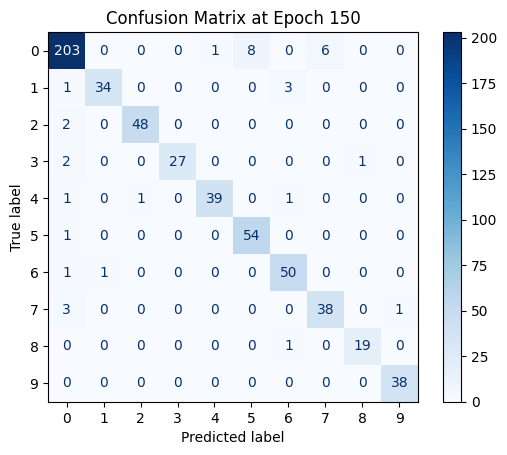

Current Testing Performance - Val: Loss nan  Acc(top1) 94.017%
Current Testing Performance - Val: Loss nan  Acc(top1) 94.359%
Finished fine tuning.
Iteration 149/205 finished in 2m16s
Total channels prunned so far: 149
 --- chonfig[8, 32, 45, 27, 46, 26, 16]
 --- save model at /home/sail/sound_project/sound_ai_v4/sys/step_3_pruning/20241119_00/uec_secondPrun_time_2024111900_prunratio80.0/9C_model_v4second_stage_prun_ratio0.8_20241119002153.pt --- 

Iteration 150 of 203 starts..
Ranking channels.. 
Skipping pruning for layer 0 as it would reduce channels below 4
Current Testing Performance - Val: Loss nan  Acc(top1) 94.188%
Fine tuning 2 epochs to recover from prunning iteration.
config[8, 32, 45, 27, 46, 26, 16]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Co

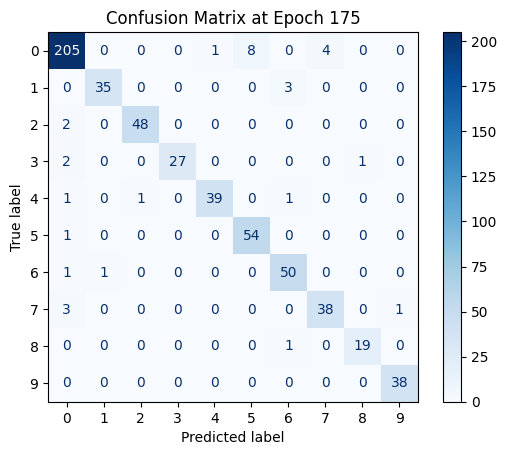

Current Testing Performance - Val: Loss nan  Acc(top1) 93.675%
Current Testing Performance - Val: Loss nan  Acc(top1) 94.701%
Finished fine tuning.
Iteration 174/205 finished in 2m16s
Total channels prunned so far: 174
 --- chonfig[8, 32, 45, 27, 46, 26, 16]
 --- save model at /home/sail/sound_project/sound_ai_v4/sys/step_3_pruning/20241119_00/uec_secondPrun_time_2024111900_prunratio80.0/9C_model_v4second_stage_prun_ratio0.8_20241119002153.pt --- 

Iteration 175 of 203 starts..
Ranking channels.. 
Skipping pruning for layer 0 as it would reduce channels below 4
Current Testing Performance - Val: Loss nan  Acc(top1) 94.530%
Fine tuning 2 epochs to recover from prunning iteration.
config[8, 32, 45, 27, 46, 26, 16]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Co

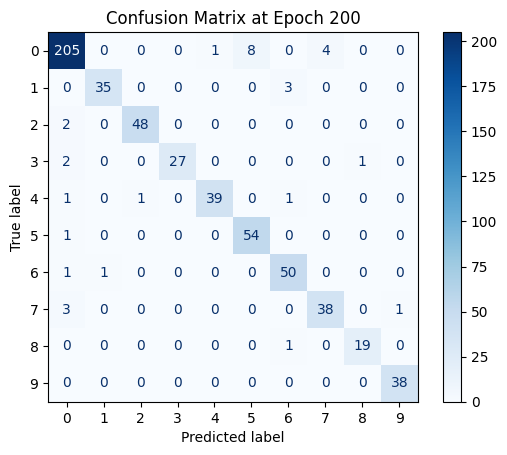

Current Testing Performance - Val: Loss nan  Acc(top1) 94.530%
Current Testing Performance - Val: Loss nan  Acc(top1) 94.188%
Finished fine tuning.
Iteration 199/205 finished in 2m16s
Total channels prunned so far: 199
 --- chonfig[8, 32, 45, 27, 46, 26, 16]
 --- save model at /home/sail/sound_project/sound_ai_v4/sys/step_3_pruning/20241119_00/uec_secondPrun_time_2024111900_prunratio80.0/9C_model_v4second_stage_prun_ratio0.8_20241119002153.pt --- 

Iteration 200 of 203 starts..
Ranking channels.. 
Skipping pruning for layer 0 as it would reduce channels below 4
Current Testing Performance - Val: Loss nan  Acc(top1) 94.359%
Fine tuning 2 epochs to recover from prunning iteration.
config[8, 32, 45, 27, 46, 26, 16]
self.net att_Model(
  (output): Sequential(
    (0): Softmax(dim=1)
  )
  (sfeb): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 9), stride=(1, 2), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Co

In [27]:
step_3_model_path = main()

In [28]:
step_3_model_path 

'/home/sail/sound_project/sound_ai_v4/sys/step_3_pruning/20241119_00/uec_secondPrun_time_2024111900_prunratio80.0/9C_model_v4second_stage_prun_ratio0.8_20241119002153.pt'

## step4

In [29]:
# step_3_model_path = '/home/sail/sound_project/sound_ai_v4/sys/step_3_pruning/20241025_18/uec_secondPrun_time_2024102518_prunratio90.0/9C_model_v4second_stage_prun_ratio0.9_20241025182638.pt'

In [30]:
step_now = 'sys/step_4_retrain'
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_step_path = f'{project_PATH}/{step_now}'
save_pt_model_path = f'{save_step_path}/{date_time}'

try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")
    
save_step_path = f'{project_PATH}/{step_now}/save_pt_model_s4'
try:
    os.mkdir(f'{project_PATH}/{step_now}')
    os.mkdir(save_step_path)
    print(f"Folder '{save_step_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_step_path}' already exists.")

try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v4/sys/step_4_retrain' already exists.
Folder '/home/sail/sound_project/sound_ai_v4/sys/step_4_retrain/save_pt_model_s4' already exists.
Folder '/home/sail/sound_project/sound_ai_v4/sys/step_4_retrain/20241119_08' created successfully.


In [31]:
from retrain import ReTrainer

In [32]:
def main():

    opt = getOpts();

    # opt.lr = 0.1
    # opt.nEpochs = ; # 1600
    # opt.schedule = [0.001, 0.003, 0.005, 0.01];
    # opt.warmup = 10;
    
    # opt.least_save_epoch = 10;
    opt.first_save_acc = 60.0;
    opt.save_val_acc = 95.0;
    opt.save_train_acc = 90.0;

    opt.pruningRatio = pr_rate
    
    save_dir = "{}/retrain_4C_after_2nd_pruning_prunratio{}_{}/".format(save_pt_model_path,opt.pruningRatio,getDateStr());
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    opt.logSaveDir = save_dir
    print(f"save dir is: {save_dir}");
    opt.second_pruned_model = step_3_model_path

    opt.saveDir = save_dir;
    # opt.device="mps";
    if torch.cuda.is_available():
        opt.device="cuda:0"; #for nVidia gpu
    else:
        opt.device="cpu"
    print(f"***Use device:{opt.device}");
    # opt.device = torch.device("cuda:0" if  else "cpu");

    opt.model_name = save_model_name+"retrained_ratio{:.4f}_vaacc{:.4f}_tracc_{:.4f}@{}epoch.pt"
    
    #Starting retraining process
    trainer = ReTrainer(opt=opt);
    trainer.Train();
    return opt.best_save_name

***Use device:cuda:0
save dir is: /home/sail/sound_project/sound_ai_v4/sys/step_4_retrain/20241119_08/retrain_4C_after_2nd_pruning_prunratio0.8_2024111908/
***Use device:cuda:0
device is: cuda:0
config is [8, 32, 45, 27, 46, 26, 16]
self.opt.config [8, 32, 45, 27, 46, 26, 16]
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
------------------------------------------------------------------------------
   Layer (type)       Input Shape      Output Shape    Param #      FLOPS #
       Conv2d-1     (1, 1, 16000)      (8, 1, 7996)         72      575,712
  BatchNorm2d-2      (8, 1, 7996)      (8, 1, 7996)         16            0
         ReLu-3      (8, 1, 7996)      (8, 1, 7996)          0       63,968
       Conv2d-4      (8, 1, 7996)     (32, 1, 3996)      1,280    5,114,880
  BatchNorm2d-5     (32, 1, 3996)     (32, 1, 3996)         64            0
         ReLu-6     (32, 1, 39

/home/sail/sound_project/sound_ai_v4/sys/retrain.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(self.opt.second_pruned_model, map_location="cuda")
/

shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.Size([585, 10])
SP-[1] Epoch: 1/300 | Time: 1m08s (Train 1m08s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.23  Acc 90.73% | Val: Loss nan  Acc(top1) 94.36%  HA 0.00| best sum 0.00@0
shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.Size([585, 10])
SP-[1] Epoch: 2/300 | Time: 1m09s (Train 1m08s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.23  Acc 90.66% | Val: Loss nan  Acc(top1) 94.02%  HA 0.00| best sum 0.00@0
shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.Size([585, 10])
SP-[1] Epoch: 3/300 | Time: 1m08s (Train 1m08s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.22  Acc 90.95% | Val: Loss nan  Acc(top1) 94.02%  HA 0.00| best sum 0.00@0
shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.Size([585, 10])
SP-[1] Epoch: 4/300 | Time: 1m08s (Train 1m08s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.23  Acc 90.62% | Val: Loss nan  Acc(top1) 94.70%  HA 0.00| best

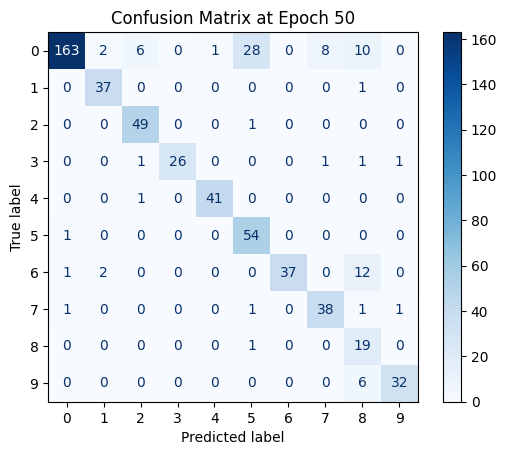

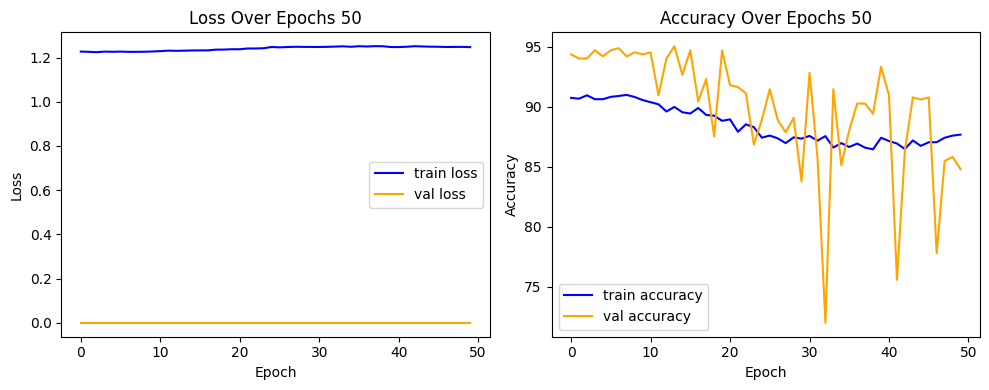

/home/sail/sound_project/sound_ai_v4/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.Size([585, 10])
SP-[1] Epoch: 51/300 | Time: 1m09s (Train 1m08s  Val 0m00s) | Train: LR 0.1  Loss 1.25  Acc 86.69% | Val: Loss nan  Acc(top1) 61.37%  HA 95.04| best sum 371.04@14
shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.Size([585, 10])
SP-[1] Epoch: 52/300 | Time: 1m09s (Train 1m09s  Val 0m00s) | Train: LR 0.1  Loss 1.25  Acc 87.04% | Val: Loss nan  Acc(top1) 93.33%  HA 95.04| best sum 371.04@14
shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.Size([585, 10])
SP-[1] Epoch: 53/300 | Time: 1m09s (Train 1m09s  Val 0m00s) | Train: LR 0.1  Loss 1.25  Acc 87.40% | Val: Loss nan  Acc(top1) 92.82%  HA 95.04| best sum 371.04@14
shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.Size([585, 10])
SP-[1] Epoch: 54/300 | Time: 1m09s (Train 1m08s  Val 0m00s) | Train: LR 0.1  Loss 1.25  Acc 87.07% | Val: Loss nan  Acc(top1) 88.38%  HA 95.04| best sum 371.04@14
shape of y_pred:torch.Size([585, 10]

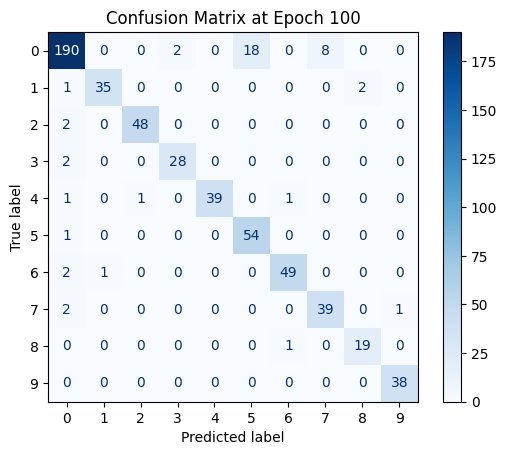

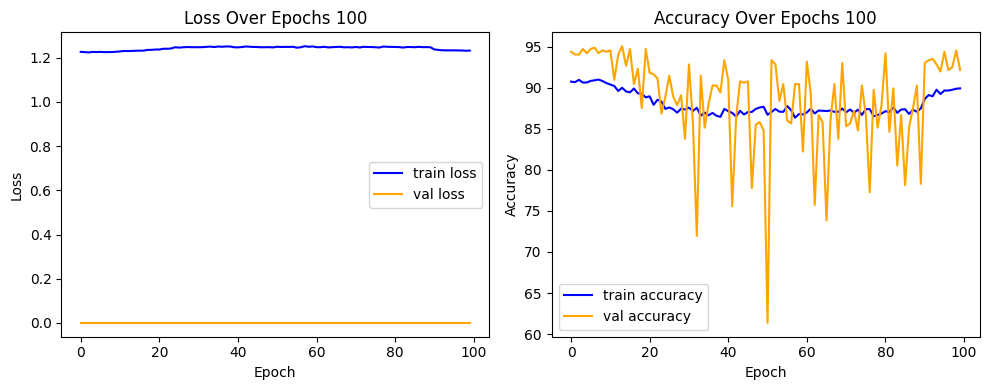

/home/sail/sound_project/sound_ai_v4/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.Size([585, 10])
SP-[1] Epoch: 101/300 | Time: 1m09s (Train 1m08s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.23  Acc 89.24% | Val: Loss nan  Acc(top1) 92.99%  HA 95.04| best sum 371.04@14
shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.Size([585, 10])
SP-[1] Epoch: 102/300 | Time: 1m09s (Train 1m08s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.23  Acc 89.75% | Val: Loss nan  Acc(top1) 94.53%  HA 95.04| best sum 371.04@14
shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.Size([585, 10])
SP-[1] Epoch: 103/300 | Time: 1m09s (Train 1m09s  Val 0m00s) | Train: LR 0.010000000000000002  Loss 1.23  Acc 89.79% | Val: Loss nan  Acc(top1) 93.68%  HA 95.04| best sum 371.04@14
shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.Size([585, 10])
save model to /home/sail/sound_project/sound_ai_v4/sys/step_4_retrain/20241119_08/retrain_4C_after_2nd_pruning_prunratio0.8_2024111908/9C_model_v

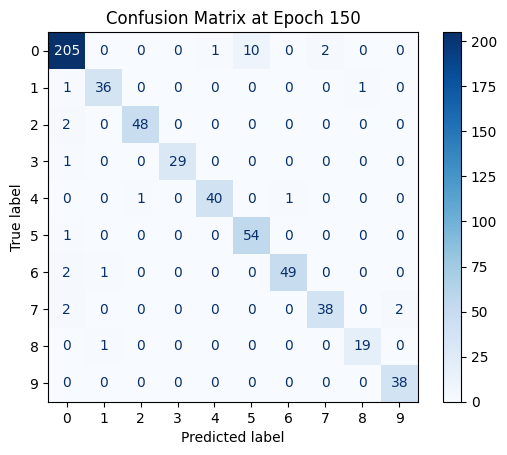

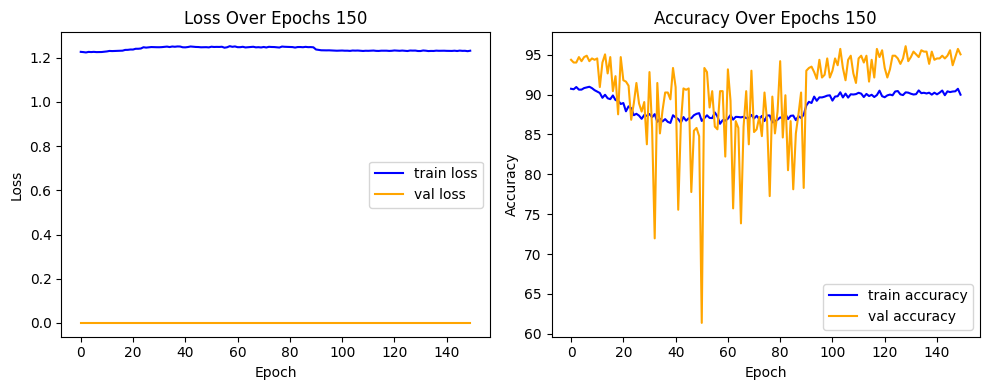

/home/sail/sound_project/sound_ai_v4/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.Size([585, 10])
save model to /home/sail/sound_project/sound_ai_v4/sys/step_4_retrain/20241119_08/retrain_4C_after_2nd_pruning_prunratio0.8_2024111908/9C_model_v4retrained_ratio80.0000_vaacc94.1880_tracc_90.2181@151epoch.pt
SP-[1] Epoch: 151/300 | Time: 1m09s (Train 1m08s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.23  Acc 90.22% | Val: Loss nan  Acc(top1) 94.19%  HA 96.07| best sum 373.50@129
shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.Size([585, 10])
save model to /home/sail/sound_project/sound_ai_v4/sys/step_4_retrain/20241119_08/retrain_4C_after_2nd_pruning_prunratio0.8_2024111908/9C_model_v4retrained_ratio80.0000_vaacc94.7009_tracc_90.3700@152epoch.pt
SP-[1] Epoch: 152/300 | Time: 1m08s (Train 1m08s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.23  Acc 90.37% | Val: Loss nan  Acc(top1) 94.70%  HA 96.07| best sum 373.50@129
shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.

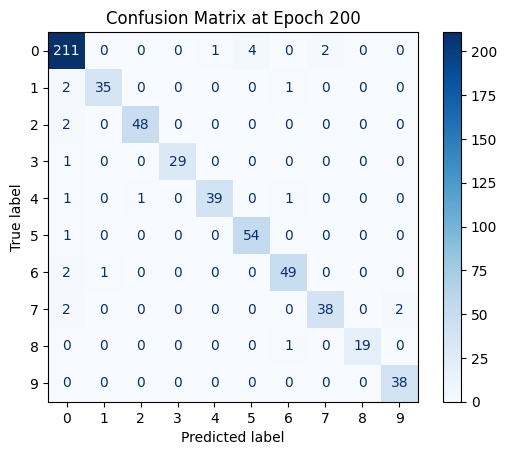

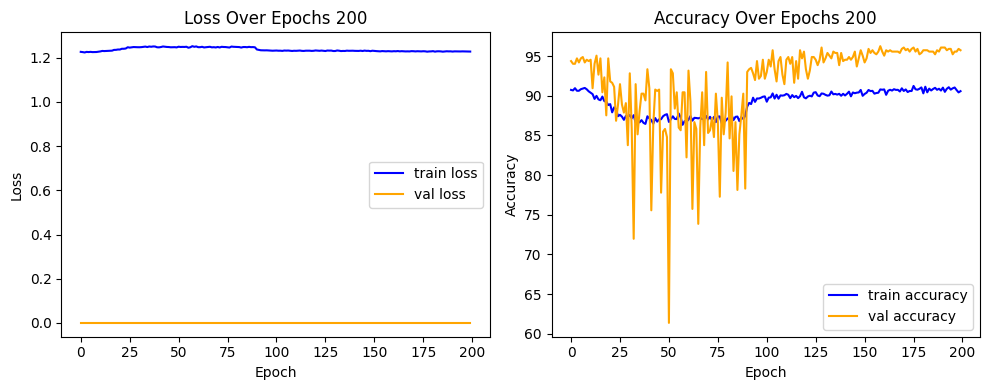

/home/sail/sound_project/sound_ai_v4/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.Size([585, 10])
save model to /home/sail/sound_project/sound_ai_v4/sys/step_4_retrain/20241119_08/retrain_4C_after_2nd_pruning_prunratio0.8_2024111908/9C_model_v4retrained_ratio80.0000_vaacc95.7265_tracc_90.4188@201epoch.pt
SP-[1] Epoch: 201/300 | Time: 1m09s (Train 1m09s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.23  Acc 90.42% | Val: Loss nan  Acc(top1) 95.73%  HA 96.24| best sum 374.76@159
shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.Size([585, 10])
save model to /home/sail/sound_project/sound_ai_v4/sys/step_4_retrain/20241119_08/retrain_4C_after_2nd_pruning_prunratio0.8_2024111908/9C_model_v4retrained_ratio80.0000_vaacc95.0427_tracc_90.6033@202epoch.pt
SP-[1] Epoch: 202/300 | Time: 1m09s (Train 1m09s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.23  Acc 90.60% | Val: Loss nan  Acc(top1) 95.04%  HA 96.24| best sum 374.76@159
shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.

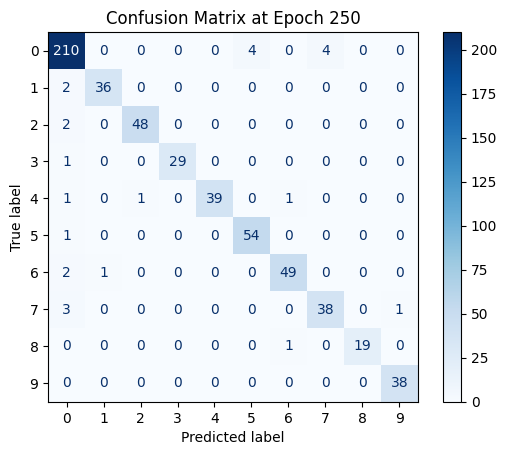

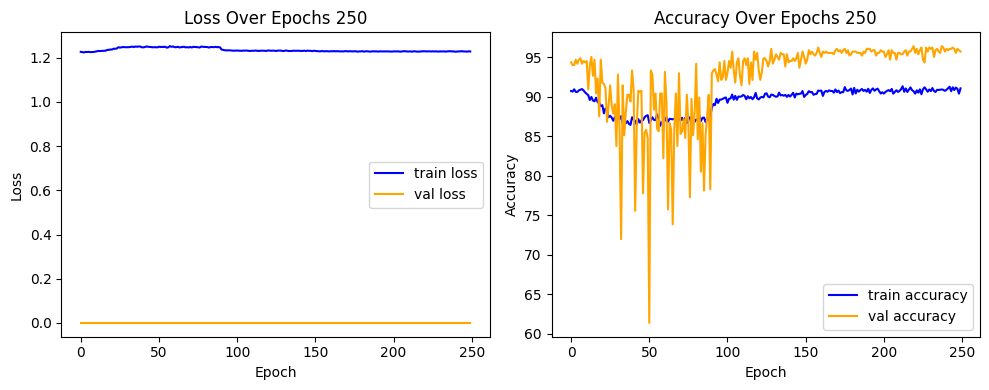

/home/sail/sound_project/sound_ai_v4/sys/retrain.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.Size([585, 10])
save model to /home/sail/sound_project/sound_ai_v4/sys/step_4_retrain/20241119_08/retrain_4C_after_2nd_pruning_prunratio0.8_2024111908/9C_model_v4retrained_ratio80.0000_vaacc95.3846_tracc_90.8257@251epoch.pt
SP-[1] Epoch: 251/300 | Time: 1m08s (Train 1m07s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.23  Acc 90.83% | Val: Loss nan  Acc(top1) 95.38%  HA 96.41| best sum 375.19@238
shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.Size([585, 10])
save model to /home/sail/sound_project/sound_ai_v4/sys/step_4_retrain/20241119_08/retrain_4C_after_2nd_pruning_prunratio0.8_2024111908/9C_model_v4retrained_ratio80.0000_vaacc95.3846_tracc_90.6847@252epoch.pt
SP-[1] Epoch: 252/300 | Time: 1m08s (Train 1m07s  Val 0m00s) | Train: LR 0.0010000000000000002  Loss 1.23  Acc 90.68% | Val: Loss nan  Acc(top1) 95.38%  HA 96.41| best sum 375.19@238
shape of y_pred:torch.Size([585, 10])
shape of y_target:torch.

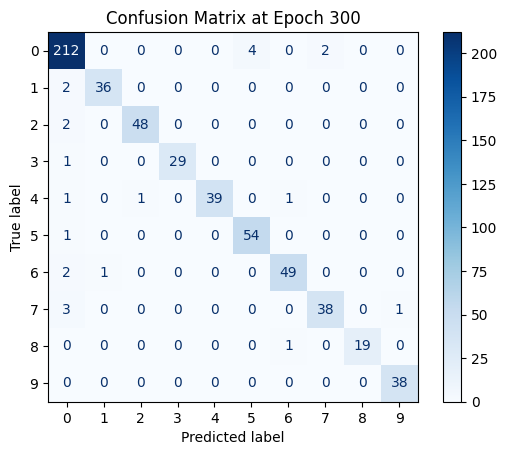

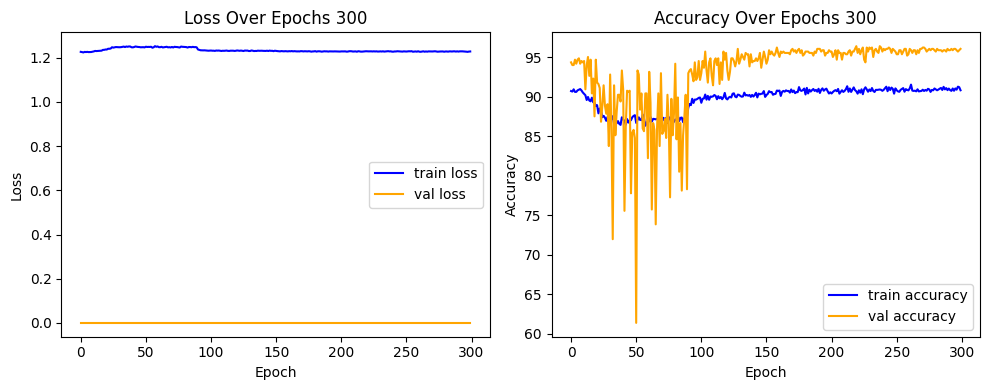

Execution finished in: 5h44m


In [33]:
step_4_model_path = main()

In [34]:
step_4_model_path

'/home/sail/sound_project/sound_ai_v4/sys/step_4_retrain/20241119_08/retrain_4C_after_2nd_pruning_prunratio0.8_2024111908/9C_model_v4retrained_ratio80.0000_vaacc95.8974_tracc_91.5419@262epoch.pt'

## step5

In [35]:
# step_4_model_path = '/home/sail/sound_project/sound_ai_v4/sys/step_4_retrain/20241028_09/retrain_4C_after_2nd_pruning_prunratio0.9_2024102809/9C_model_v4retrained_ratio90.0000_vaacc95.4023_tracc_90.8088@285epoch.pt'

In [36]:
step_now = 'sys/step_5_conv_int8'
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_step_path = f'{project_PATH}/{step_now}/save_pt_model_s5'
save_pt_model_path = f'{save_step_path}/{date_time}'


In [37]:
date_time = datetime.now().strftime("%Y%m%d_%H")  # %M
save_pt_model_path = f'{project_PATH}/{step_now}/save_pt_model_s5'

save_tflite_model_path = f'{project_PATH}/{step_now}/save_tflite_model_s5'
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

try:
    os.mkdir(save_tflite_model_path)
    print(f"Folder '{save_tflite_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_tflite_model_path}' already exists.")

save_pt_model_path = f'{project_PATH}/{step_now}/save_pt_model_s5/{date_time}'

save_tflite_model_path = f'{project_PATH}/{step_now}/save_tflite_model_s5/{date_time}'
try:
    os.mkdir(save_pt_model_path)
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")

try:
    os.mkdir(save_pt_model_path+'/uncompressed_qat_models')
    print(f"Folder '{save_pt_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_pt_model_path}' already exists.")
    
try:
    os.mkdir(save_tflite_model_path)
    print(f"Folder '{save_tflite_model_path}' created successfully.")
except FileExistsError:
    print(f"Folder '{save_tflite_model_path}' already exists.")

Folder '/home/sail/sound_project/sound_ai_v4/sys/step_5_conv_int8/save_pt_model_s5' already exists.
Folder '/home/sail/sound_project/sound_ai_v4/sys/step_5_conv_int8/save_tflite_model_s5' already exists.
Folder '/home/sail/sound_project/sound_ai_v4/sys/step_5_conv_int8/save_pt_model_s5/20241119_14' created successfully.
Folder '/home/sail/sound_project/sound_ai_v4/sys/step_5_conv_int8/save_pt_model_s5/20241119_14' created successfully.
Folder '/home/sail/sound_project/sound_ai_v4/sys/step_5_conv_int8/save_tflite_model_s5/20241119_14' created successfully.


In [38]:
def display_info(opt):
    print('+------------------------------+');
    print('| {} Sound classification'.format(opt.netType));
    print('+------------------------------+');
    print('| dataset  : {}'.format(opt.dataset));
    print('| nEpochs  : {}'.format(opt.nEpochs));
    print('| LRInit   : {}'.format(opt.lr));
    print('| schedule : {}'.format(opt.schedule));
    print('| warmup   : {}'.format(opt.warmup));
    print('| batchSize: {}'.format(opt.batchSize));
    print('| nFolds: {}'.format(opt.nFolds));
    print('| Splits: {}'.format(opt.splits));
    print('| Device: {}'.format(opt.device));
    print('| Model Path: {}'.format(opt.model_path));
    print('| Model Name: {}'.format(opt.model_name));
    print('+------------------------------+');

In [39]:
from convint8 import QATTrainer

In [40]:
def main():
    opt = getOpts();#opts.parse();
    opt.device = 'cpu';
    opt.saveInfo = "uec_v2.2_sail1014"
    opt.model_path = step_4_model_path

    opt.save_tflite_model_path = save_tflite_model_path
    opt.logSaveDir = opt.save_tflite_model_path 
    opt.save_pt_model_path = save_pt_model_path
    timeStr = genDataTimeStr();
    opt.model_name = save_model_name+"qat_model_{}_{}".format(opt.saveInfo,timeStr);
   
    opt.lr = 0.01; # 0.1
    opt.nEpochs = 150; # 1600
    # opt.schedule = [0.05, 0.1, 0.3, 0.5];
    opt.schedule = [0.001, 0.003, 0.005, 0.01];
    # opt.warmup = 10;

    opt.split = 1;
    opt.hasQuated = False;
    display_info(opt);
    trainer = QATTrainer(opt);

    print('Testing performance of the provided model.....');
    trainer.TestModel();

    print('Quantization process is started.....');
    trainer.QuantizeModel();
    print('Quantization done');

    return opt.tflite_path
    # print('Testing quantized model.');
    # trainer.TestModel(True);
    # print('Finished');

***Use device:cuda:0
+------------------------------+
| add_attention Sound classification
+------------------------------+
| dataset  : v4
| nEpochs  : 150
| LRInit   : 0.01
| schedule : [0.001, 0.003, 0.005, 0.01]
| warmup   : 10
| batchSize: 128
| nFolds: 1
| Splits: [1]
| Device: cpu
| Model Path: /home/sail/sound_project/sound_ai_v4/sys/step_4_retrain/20241119_08/retrain_4C_after_2nd_pruning_prunratio0.8_2024111908/9C_model_v4retrained_ratio80.0000_vaacc95.8974_tracc_91.5419@262epoch.pt
| Model Name: 9C_model_v4qat_model_uec_v2.2_sail1014_20241119140418
+------------------------------+
device is: cpu
Testing performance of the provided model.....
has not quanted, load unquanted model...
[1, 8, 32, 1, 45, 27, 46, 26, 16, 10]
self.ch_config [1, 8, 32, 1, 45, 27, 46, 26, 16, 10]
+----------------------------------------------------------------------------+
+                           Pytorch Model Summary                            +
--------------------------------------------------

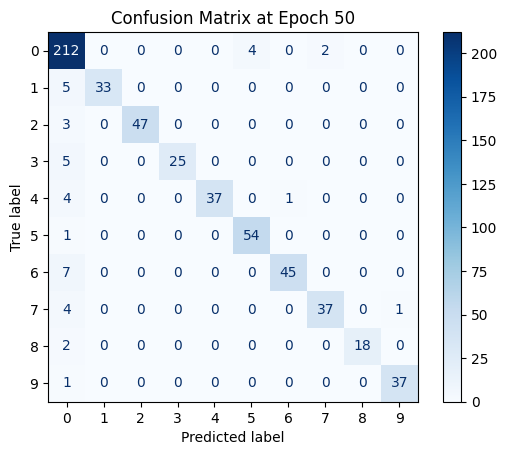

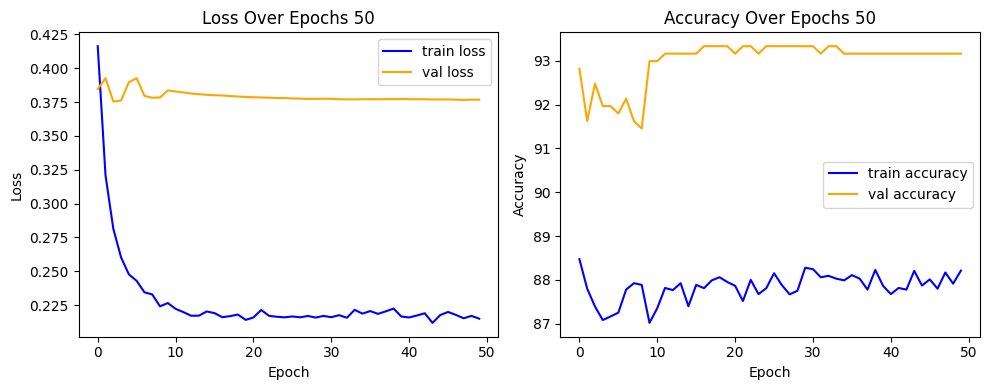

current best Acc is 93.33333587646484
pass in acc is 93.16239166259766
SP-[1] Epoch: 51/150 | Time: 1m07s (Train 1m07s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.21  Acc 87.72% | Val: Loss 0.38  Acc(top1) 93.16% | HA 93.33@17
current best Acc is 93.33333587646484
pass in acc is 93.16239166259766
SP-[1] Epoch: 52/150 | Time: 1m07s (Train 1m07s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.22  Acc 87.64% | Val: Loss 0.38  Acc(top1) 93.16% | HA 93.33@17
current best Acc is 93.33333587646484
pass in acc is 93.16239166259766
SP-[1] Epoch: 53/150 | Time: 1m08s (Train 1m07s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.22  Acc 88.36% | Val: Loss 0.38  Acc(top1) 93.16% | HA 93.33@17
current best Acc is 93.33333587646484
pass in acc is 93.16239166259766
SP-[1] Epoch: 54/150 | Time: 1m07s (Train 1m07s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.22  Acc 87.65% | Val: Loss 0.38  Acc(top1) 93.16% | HA 93.33@17
current best Acc is 93.33333587646484
pass in ac

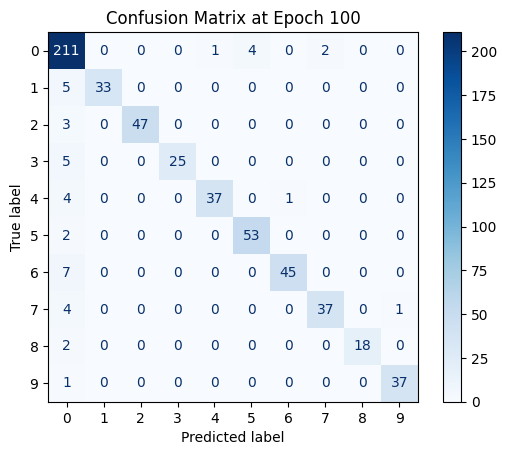

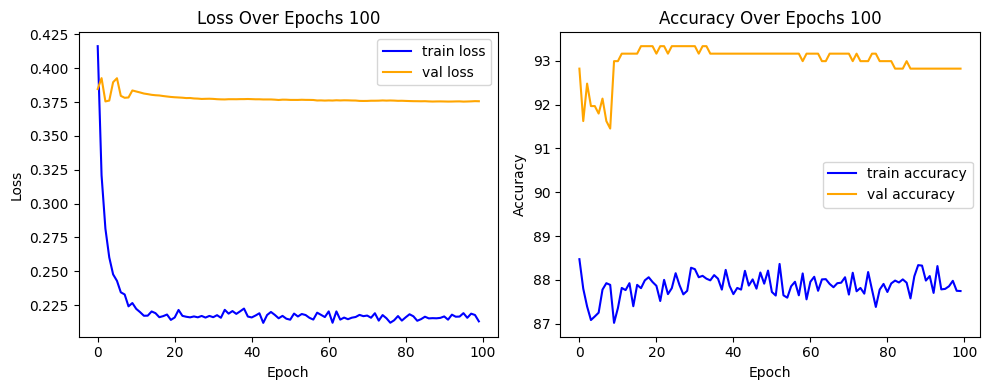

current best Acc is 93.33333587646484
pass in acc is 92.82051086425781
SP-[1] Epoch: 101/150 | Time: 1m07s (Train 1m07s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.22  Acc 87.54% | Val: Loss 0.38  Acc(top1) 92.82% | HA 93.33@17
current best Acc is 93.33333587646484
pass in acc is 92.82051086425781
SP-[1] Epoch: 102/150 | Time: 1m07s (Train 1m06s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.21  Acc 88.29% | Val: Loss 0.38  Acc(top1) 92.82% | HA 93.33@17
current best Acc is 93.33333587646484
pass in acc is 92.991455078125
SP-[1] Epoch: 103/150 | Time: 1m06s (Train 1m06s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.21  Acc 87.75% | Val: Loss 0.38  Acc(top1) 92.99% | HA 93.33@17
current best Acc is 93.33333587646484
pass in acc is 92.82051086425781
SP-[1] Epoch: 104/150 | Time: 1m07s (Train 1m07s  Val 0m00s) | Train: lr 1.0000000000000002e-06  Loss 0.22  Acc 88.42% | Val: Loss 0.38  Acc(top1) 92.82% | HA 93.33@17
current best Acc is 93.33333587646484
pass in 

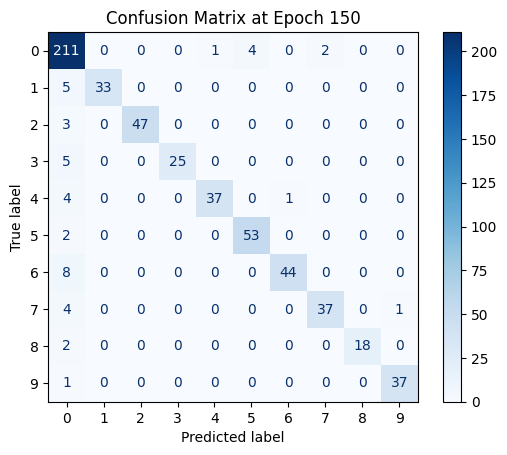

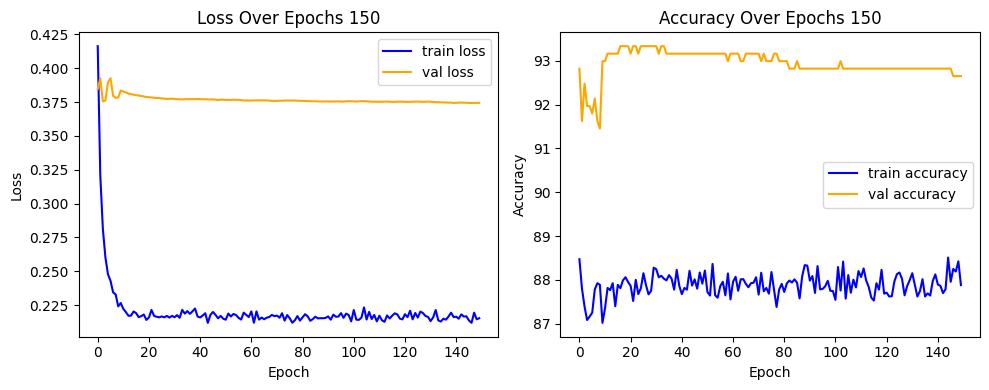

Execution finished in: 2h48m
Post Training Quantization: Convert done
Size of model after quantization
Size (MB): 0.04659
device is: cpu
torch.Size([585, 10])
Testing: Acc(top1) 91.79%


INFO (tinynn.converter.base) Generated model saved to /home/sail/sound_project/sound_ai_v4/sys/step_5_conv_int8/save_tflite_model_s5/20241119_14/9C_model_v4qat_model_uec_v2.2_sail1014_20241119140418.tflite


Quantization done


In [41]:
tflite_path = main()

## check

In [42]:
tflite_path

'/home/sail/sound_project/sound_ai_v4/sys/step_5_conv_int8/save_tflite_model_s5/20241119_14/9C_model_v4qat_model_uec_v2.2_sail1014_20241119140418.tflite'

In [43]:
import tensorflow as tf


interpreter = tf.lite.Interpreter(model_path=tflite_path)

interpreter.allocate_tensors()

# 獲取張量細節
tensor_details = interpreter.get_tensor_details()

# 檢查每個張量的類型
for tensor in tensor_details:
    tensor_name = tensor['name']
    tensor_type = tensor['dtype']
    print(f"Tensor: {tensor_name}, Type: {tensor_type}")

# 檢查輸入和輸出張量的類型
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\nInput Tensors:")
for input_tensor in input_details:
    print(f"Name: {input_tensor['name']}, Type: {input_tensor['dtype']}")

print("\nOutput Tensors:")
for output_tensor in output_details:
    print(f"Name: {output_tensor['name']}, Type: {output_tensor['dtype']}")


2024-11-19 16:53:04.301269: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-19 16:53:04.309083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 16:53:04.315807: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 16:53:04.317880: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 16:53:04.323535: I tensorflow/core/platform/cpu_feature_guar

Tensor: input.7_attr_1, Type: <class 'numpy.int32'>
Tensor: fuse_attr_3, Type: <class 'numpy.int8'>
Tensor: input.14_te_transform_1_te_attr_2, Type: <class 'numpy.int32'>
Tensor: fuse_attr_2, Type: <class 'numpy.int32'>
Tensor: x.1_transform_1, Type: <class 'numpy.int8'>
Tensor: input.8_attr_1, Type: <class 'numpy.int32'>
Tensor: fuse_attr_6, Type: <class 'numpy.int8'>
Tensor: fuse_attr_8, Type: <class 'numpy.int8'>
Tensor: input.6_te_transform, Type: <class 'numpy.int8'>
Tensor: input.2_te_transform, Type: <class 'numpy.int8'>
Tensor: input.4_transform, Type: <class 'numpy.int8'>
Tensor: fuse_attr_11, Type: <class 'numpy.int32'>
Tensor: input0.1_attr_1, Type: <class 'numpy.int32'>
Tensor: input.12_te_transform, Type: <class 'numpy.int8'>
Tensor: 124, Type: <class 'numpy.int8'>
Tensor: input.8_te_transform, Type: <class 'numpy.int8'>
Tensor: fuse_attr_4, Type: <class 'numpy.int8'>
Tensor: input0.1_te_transform, Type: <class 'numpy.int8'>
Tensor: Xq.1_attr_1, Type: <class 'numpy.int32'>

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [44]:
tensor_details

[{'name': 'input.7_attr_1',
  'index': 0,
  'shape': array([32], dtype=int32),
  'shape_signature': array([32], dtype=int32),
  'dtype': numpy.int32,
  'quantization': (5.183331813896075e-05, 0),
  'quantization_parameters': {'scales': array([5.1833318e-05], dtype=float32),
   'zero_points': array([0], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'fuse_attr_3',
  'index': 1,
  'shape': array([8, 1, 9, 1], dtype=int32),
  'shape_signature': array([8, 1, 9, 1], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.010482564568519592, 0),
  'quantization_parameters': {'scales': array([0.01048256], dtype=float32),
   'zero_points': array([0], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'input.14_te_transform_1_te_attr_2',
  'index': 2,
  'shape': array([4, 2], dtype=int32),
  'shape_signature': array([4, 2], dtype=int32),
  'dtype': numpy.int32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scal

# 

In [45]:
tflite_ = tflite_path
tflite_.split('/')[0]

''

In [46]:
c_ = f"/{tflite_.split('/')[1]}/{tflite_.split('/')[2]}/{tflite_.split('/')[3]}/{tflite_.split('/')[4]}/{tflite_.split('/')[5]}/{tflite_.split('/')[6]}/{tflite_.split('/')[7]}/{tflite_.split('/')[8]}/{save_name}"#tflite_[:-7]+'.cc'

! xxd -i {tflite_} > {c_}
REPLACE_TEST = f"model_9C_{today}_bysail";
!sed -i 's/'{REPLACE_TEST}'/g_model/g' {c_}

In [47]:
import tensorflow as tf
import numpy as np

def calculate_arena_size(tflite_model_path):
    """
    計算 TFLite 模型的內存需求（Arena size）。

    :param tflite_model_path: .tflite 模型文件的路徑
    :return: 估算的總內存需求（MB）
    """
    # 加載 TFLite 模型
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # 獲取所有張量的詳細信息
    tensor_details = interpreter.get_tensor_details()

    # 計算參數內存
    total_params = 0
    params_memory = 0
    activations_memory = 0

    for tensor in tensor_details:
        name = tensor['name'].lower()
        shape = tensor['shape']
        dtype = tensor['dtype']

        # 根據數據類型確定每個元素的字節數
        if dtype == np.float32:
            bytes_per_element = 4
        elif dtype == np.int8:
            bytes_per_element = 1
        elif dtype == np.int16:
            bytes_per_element = 2
        elif dtype == np.uint8:
            bytes_per_element = 1
        else:
            bytes_per_element = 4  # 默認為 float32

        tensor_size_mb = (np.prod(shape) * bytes_per_element) / (1024 ** 2)  # 轉換為 MB

        # 假設 'weight' 和 'bias' 為參數，其他為激活
        if 'weight' in name or 'bias' in name:
            total_params += np.prod(shape)
            params_memory += (np.prod(shape) * bytes_per_element) / (1024 ** 2)  # MB
        else:
            activations_memory += tensor_size_mb  # MB

    # 臨時內存估算（假設激活內存的 20% 為臨時內存）
    temporary_memory = activations_memory * 0.2

    # 總內存需求
    total_memory = params_memory + activations_memory + temporary_memory

    print(f"dtype：{dtype} ")
    print(f"參數內存需求：{params_memory:.2f} MB")
    print(f"激活內存需求：{activations_memory:.2f} MB")
    print(f"臨時內存需求（估算）：{temporary_memory:.2f} MB")
    print(f"總內存需求（估算的 Arena size）：{total_memory:.2f} MB")

    return total_memory

# 使用範例
tflite_model = tflite_path
arena_size = calculate_arena_size(tflite_model)

dtype：<class 'numpy.int8'> 
參數內存需求：0.00 MB
激活內存需求：0.42 MB
臨時內存需求（估算）：0.08 MB
總內存需求（估算的 Arena size）：0.50 MB


In [48]:
# import tensorflow as tf


# interpreter = tf.lite.Interpreter(model_path='/hd/Rick/desktop/Works/Projects/TransferLearning_for_ACDNet/Finall_Models_Save/Alarm_Detection/Pruning_Ratio_0.6_0.85_20240221/qat_model_0.6_0.85_ratio_qatacc_95.4_20240221181601_total_epochs_200.tflite')

# interpreter.allocate_tensors()

# # 獲取張量細節
# tensor_details = interpreter.get_tensor_details()

# # 檢查每個張量的類型
# for tensor in tensor_details:
#     tensor_name = tensor['name']
#     tensor_type = tensor['dtype']
#     print(f"Tensor: {tensor_name}, Type: {tensor_type}")

# # 檢查輸入和輸出張量的類型
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# print("\nInput Tensors:")
# for input_tensor in input_details:
#     print(f"Name: {input_tensor['name']}, Type: {input_tensor['dtype']}")

# print("\nOutput Tensors:")
# for output_tensor in output_details:
#     print(f"Name: {output_tensor['name']}, Type: {output_tensor['dtype']}")


In [49]:
# tensor_details

In [50]:
# import re

# # 假設模型數據存儲在名為 model.cc 的文件中
# input_file = '/home/sail/sound_project/sound_ai_v2/sys/step_5_conv_int8/save_tflite_model_s5/20241015_09/model_9C_v222_1015_pr09_byChristine.cc'
# output_file = 'model.tflite'

# # 讀取 C 文件
# with open(input_file, 'r') as f:
#     data = f.read()

# # 正則表達式匹配模型數據陣列
# match = re.search(r'unsigned char [^;]+', data, re.DOTALL)
# if not match:
#     raise ValueError("未找到模型數據陣列。請檢查文件內容。")

# # 提取十六進制數據
# hex_data = match.group(0)
# hex_values = re.findall(r'0x([0-9A-Fa-f]{2})', hex_data)

# # 將十六進制轉換為二進制
# binary_data = bytes(int(h, 16) for h in hex_values)

# # 保存為 .tflite 文件
# with open(output_file, 'wb') as f:
#     f.write(binary_data)



In [51]:
# import tensorflow as tf


# interpreter = tf.lite.Interpreter(model_path=output_file)

# interpreter.allocate_tensors()

# # 獲取張量細節
# tensor_details = interpreter.get_tensor_details()

# # 檢查每個張量的類型
# for tensor in tensor_details:
#     tensor_name = tensor['name']
#     tensor_type = tensor['dtype']
#     print(f"Tensor: {tensor_name}, Type: {tensor_type}")

# # 檢查輸入和輸出張量的類型
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# print("\nInput Tensors:")
# for input_tensor in input_details:
#     print(f"Name: {input_tensor['name']}, Type: {input_tensor['dtype']}")

# print("\nOutput Tensors:")
# for output_tensor in output_details:
#     print(f"Name: {output_tensor['name']}, Type: {output_tensor['dtype']}")
